In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy, ensure_np_array
from wfsc_tests.imshows import *

import cgi_phasec_poppy as cgi
reload(cgi)

# iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
iefc_dir = Path('/home/kianmilani/Projects/roman-cgi-iefc-data')


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


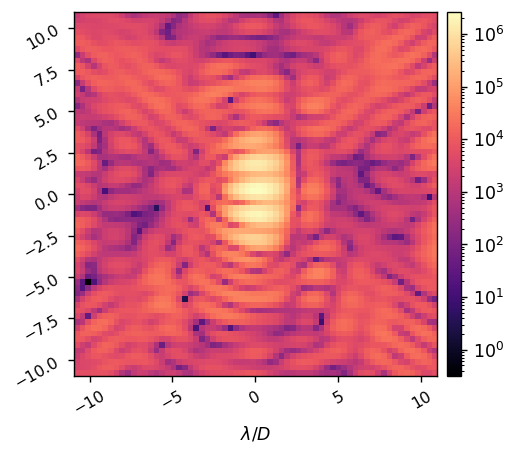

2580894.0073849405

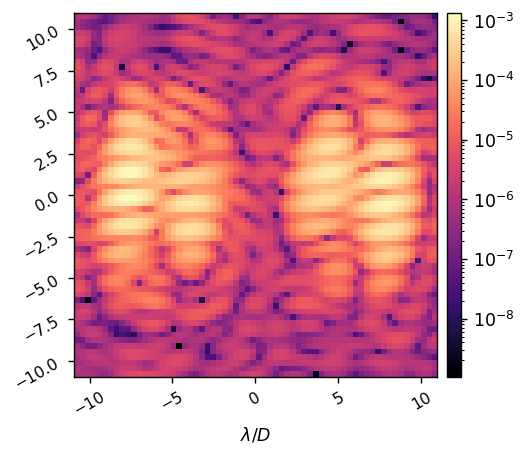

In [3]:
reload(cgi)

source_flux = 2.0208517e8 * u.ph/u.s/u.m**2 # flux of 47 UMa at 575nm with 10% bandpass

c = cgi.CGI(cgi_mode='spc-spec', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=source_flux,
            exp_time=5)

npsf = c.npsf
Nact = c.Nact

c.use_fpm = False
ref_unocc_im = c.snap()
imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

c.use_fpm = True
c.source_flux = source_flux/max_ref # divide the source flux to get nominal contrast images
ref_im = c.snap()
imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

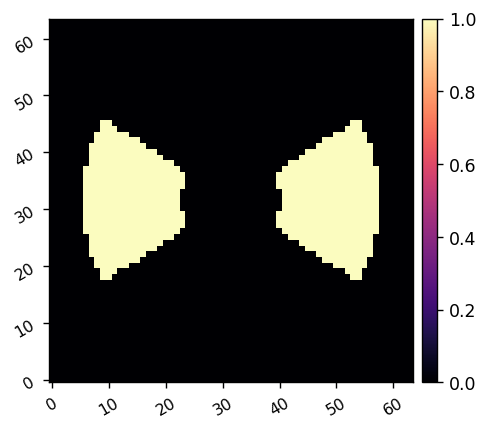

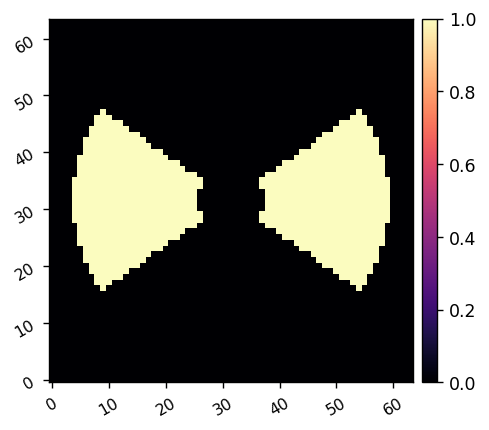

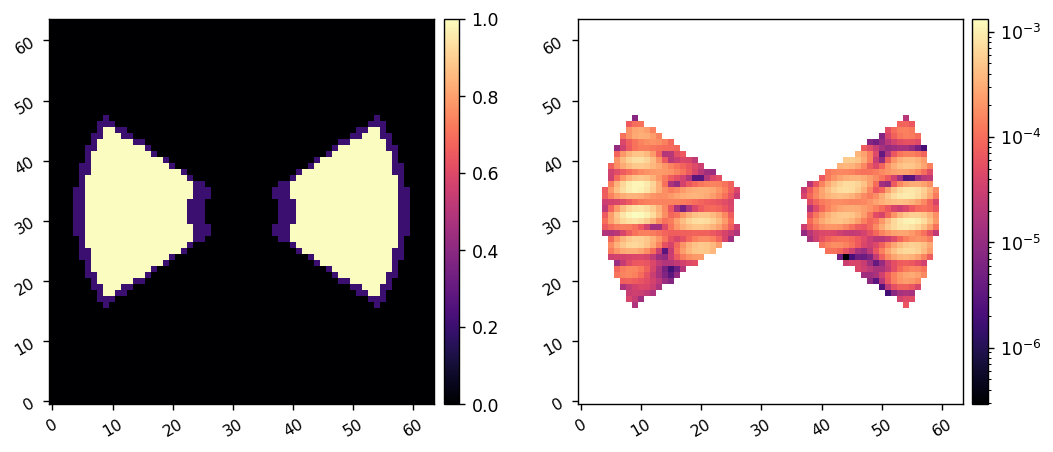

In [4]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)

xfp = (xp.arange(-npsf//2, npsf//2) +1/2) * c.psf_pixelscale_lamD
xf,yf = xp.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 9
rot = 0

# Create the mask that is used to select which region to make dark.
roi1_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'angle':65,
#     'rotation':45,
}
roi1= wfsc.utils.create_bowtie_focal_plane_mask(xf, yf, roi1_params, plot=True)

# Create the mask that is used to select which region to make dark.
roi2_params = {
    'inner_radius' : iwa-1,
    'outer_radius' : owa+0.5,
    'angle':70,
}
roi2 = wfsc.utils.create_bowtie_focal_plane_mask(xf, yf, roi2_params, plot=True)

relative_weight = 0.2
weight_map = roi1 + relative_weight*(roi2*~roi1)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)

# Create probe and fourier modes

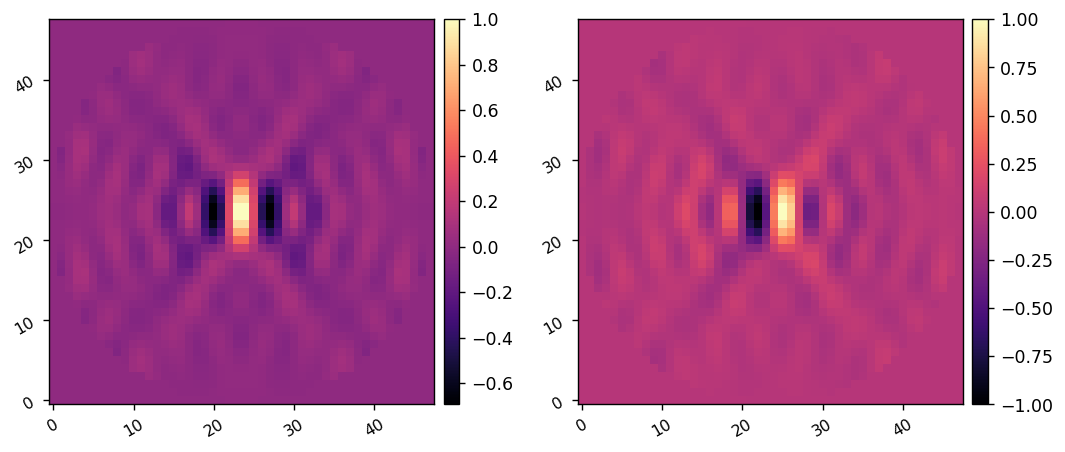

In [5]:
probe_amp = 2.5e-8
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(xf>0), fourier_sampling=1) 
probe_modes = wfsc.utils.create_fourier_probes(fourier_modes, plot=True)

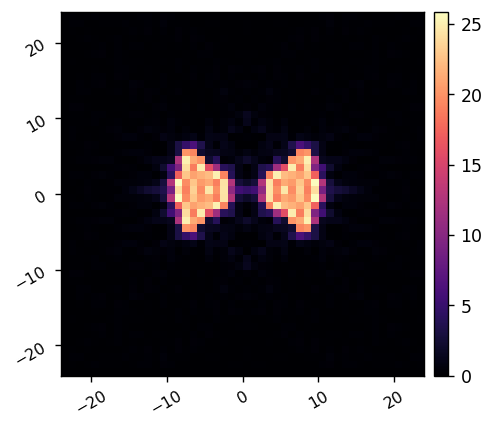

In [6]:
reload(wfsc.utils)
probe_fft = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(wfsc.utils.pad_or_crop(xp.array(probe_modes[0]), 48))))
imshow1(xp.abs(probe_fft), pxscl=1/1)

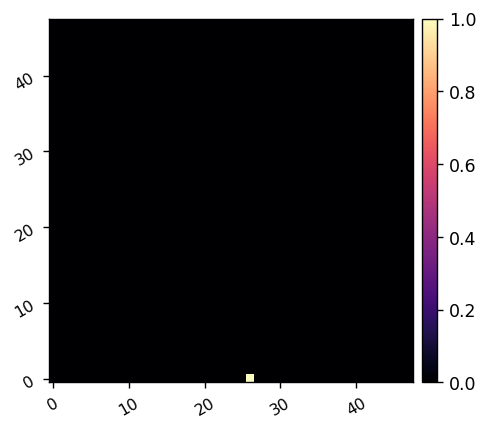

In [7]:
Nacts = int(c.dm_mask.sum())

calib_amp = 2.5e-9

calib_modes = xp.zeros((Nacts, c.Nact, c.Nact))
count=0
for i in range(c.Nact):
    for j in range(c.Nact):
        if c.dm_mask[i,j]:
            calib_modes[count, i,j] = 1
            count+=1
            
calib_modes = calib_modes[:,:].reshape(Nacts, c.Nact**2)

import time
for i in range(Nacts):
    try:
        wfsc.imshow1(calib_modes[i].reshape(Nact,Nact))
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

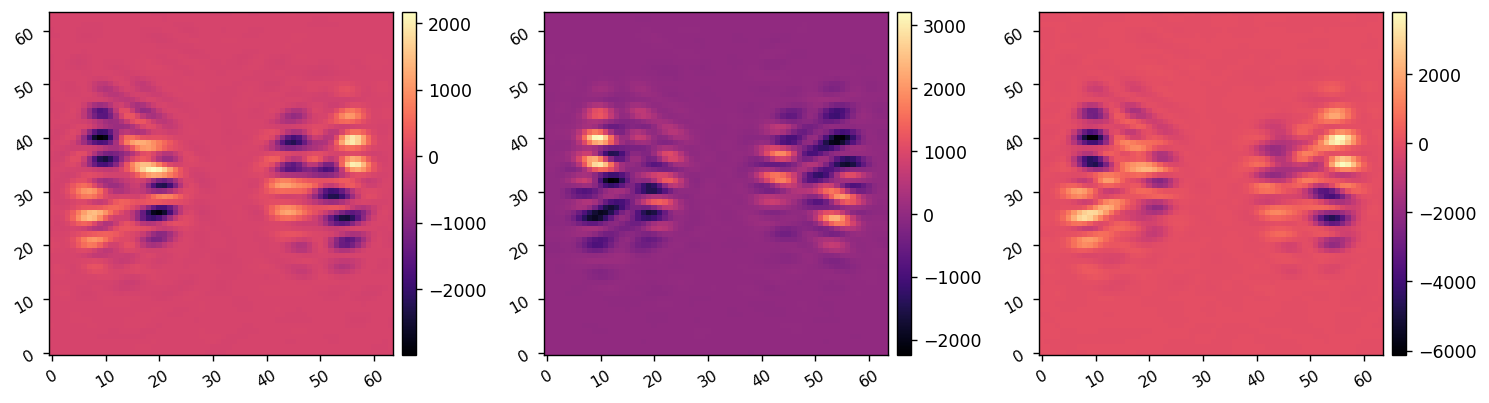

In [8]:
reload(wfsc.iefc)

differential_images, single_images = wfsc.iefc_2dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(2, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [9]:
reload(wfsc.iefc_2dm)

response_matrix, response_cube = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, ensure_np_array(calib_modes), 
                                                         return_all=True)


Calibrating iEFC...


KeyboardInterrupt: 

In [9]:
date = 20230630
response_matrix = xp.array(fits.getdata(iefc_dir/'response-data'/f'spc_spec_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(iefc_dir/'response-data'/f'spc_spec_iefc_2dm_poke_response_cube_{date}.fits'))

In [10]:
response_cube.shape

(3560, 2, 4096)

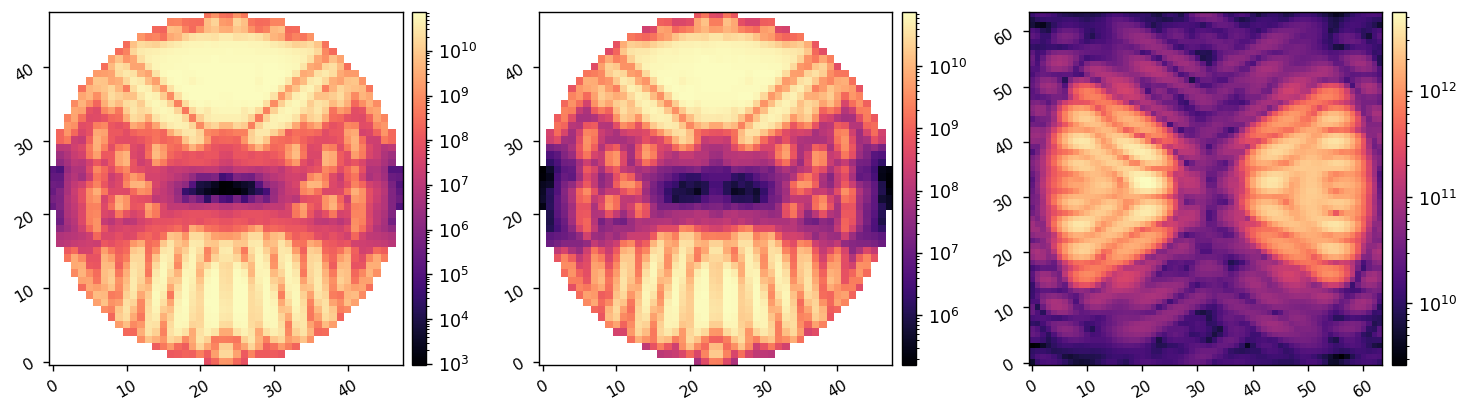

In [11]:
reload(wfsc.utils)
dm1_response_sum = wfsc.utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_cube)**2, axis=(1,2)))[::2], c.dm_mask)
dm2_response_sum = wfsc.utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_cube)**2, axis=(1,2)))[1::2], c.dm_mask)
fp_response_sum = xp.sum(abs(response_cube), axis=(0,1)).reshape(npsf, npsf)

wfsc.imshow3(dm1_response_sum , dm2_response_sum, fp_response_sum, lognorm=True)

# Run IEFC

In [28]:
len(probe_modes)

2

(1808, 1808) (1808, 3560)
Running I-EFC...
	Closed-loop iteration 1 / 10


(3560,)

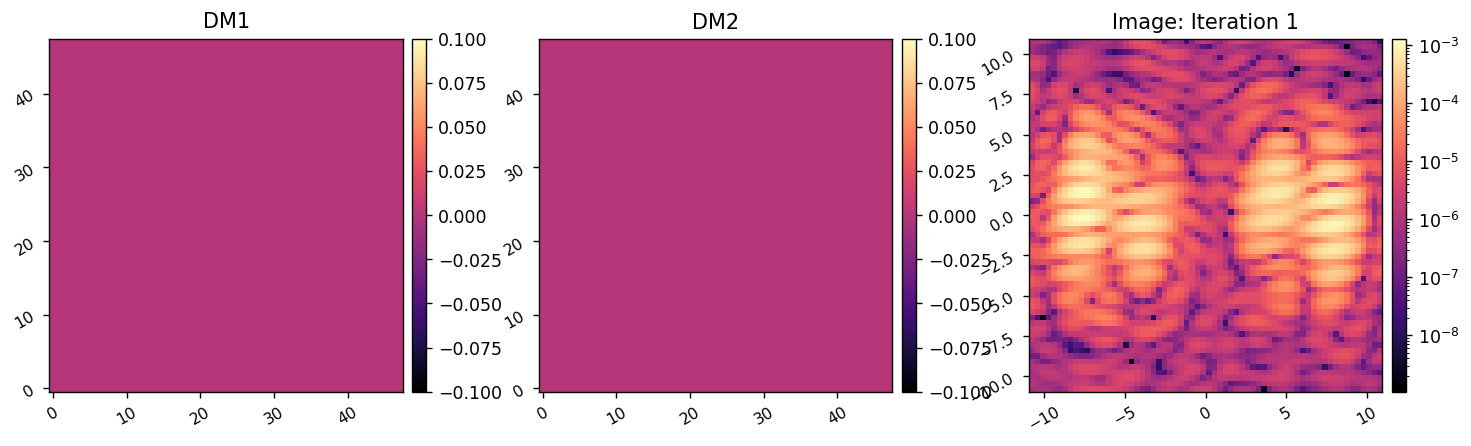

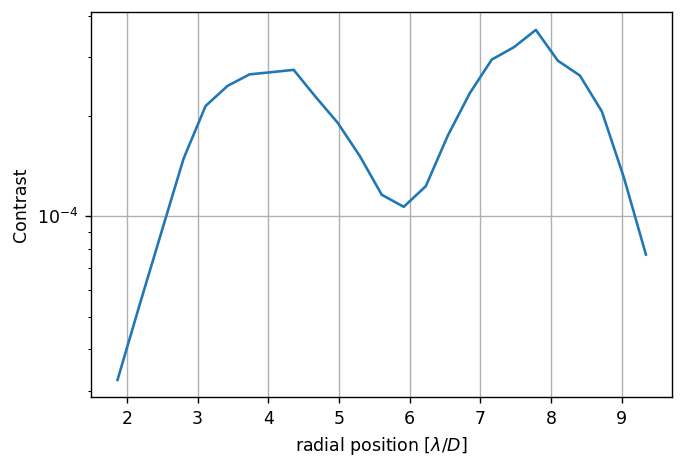

	Closed-loop iteration 2 / 10


(3560,)

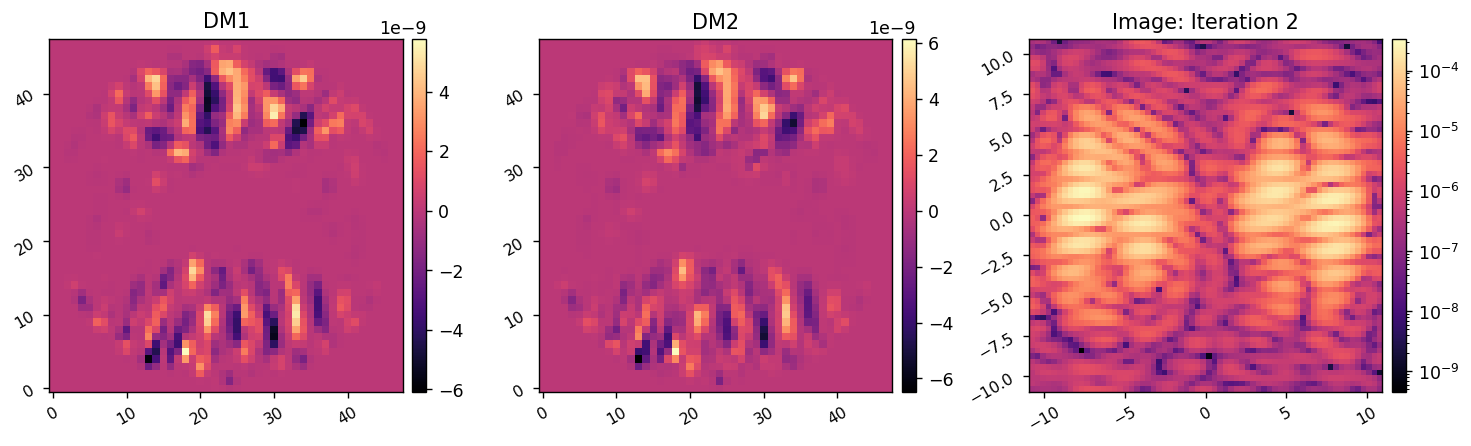

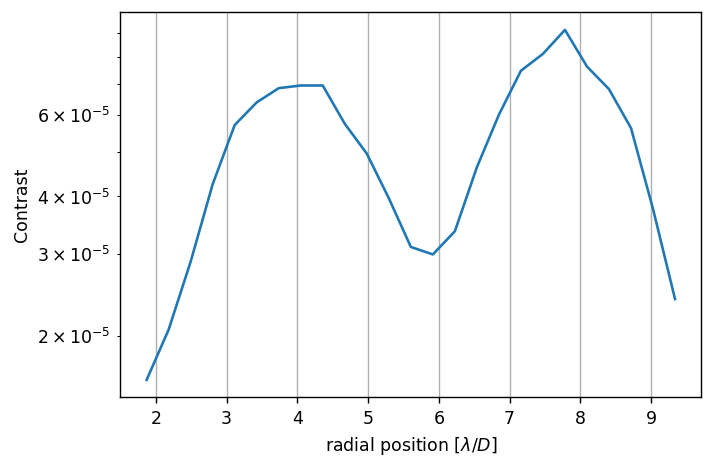

	Closed-loop iteration 3 / 10


(3560,)

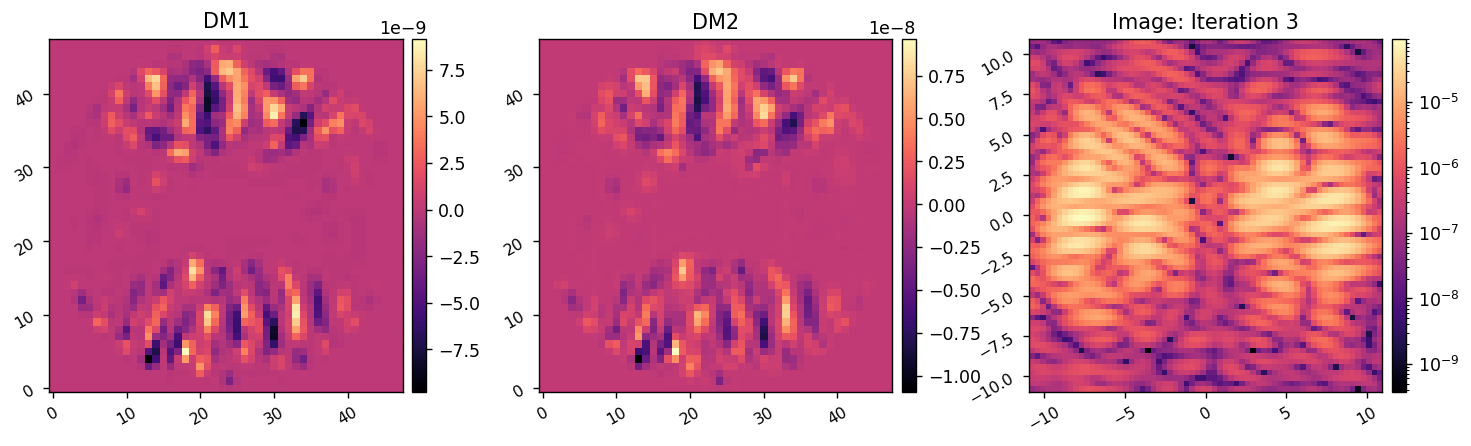

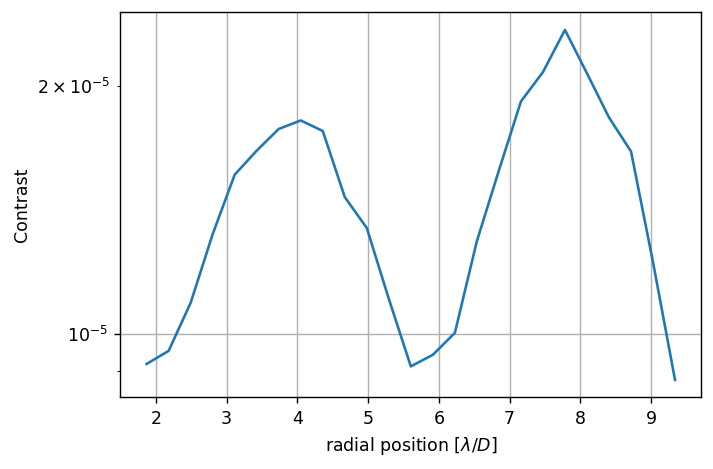

	Closed-loop iteration 4 / 10


(3560,)

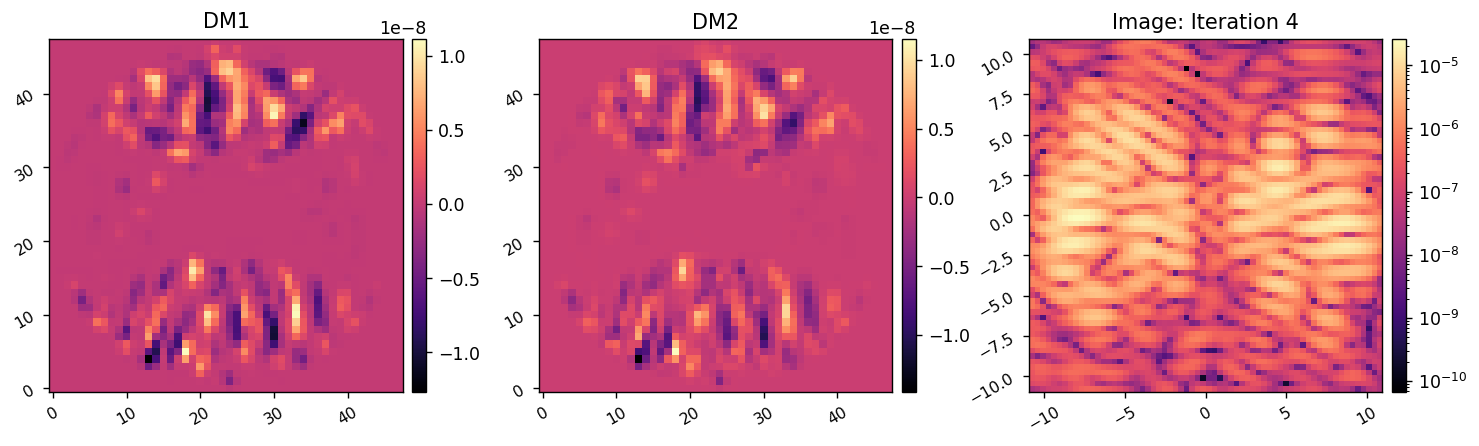

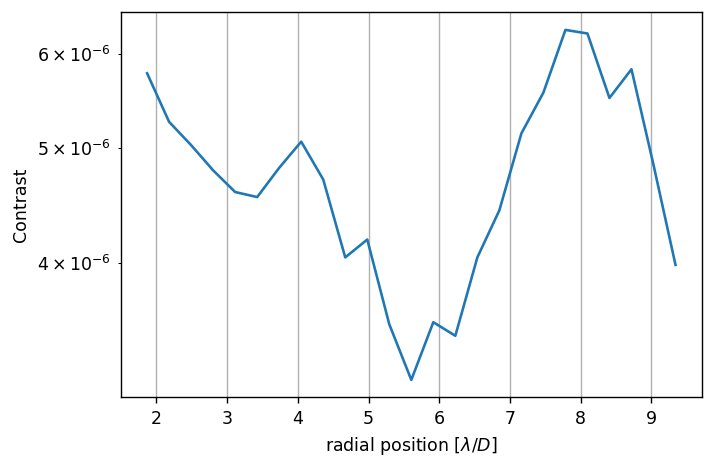

	Closed-loop iteration 5 / 10


(3560,)

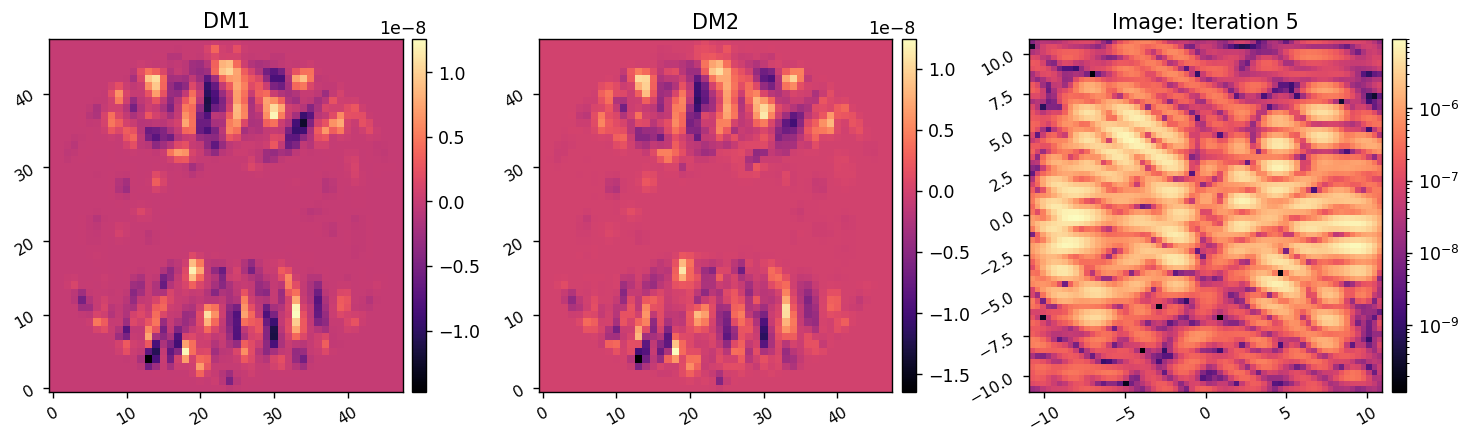

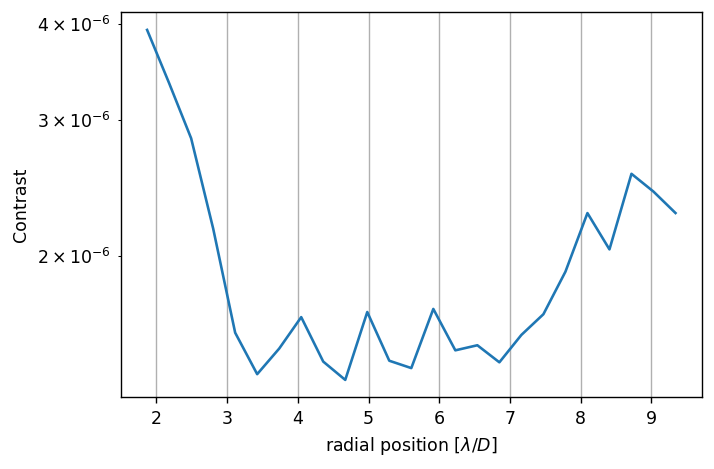

	Closed-loop iteration 6 / 10


(3560,)

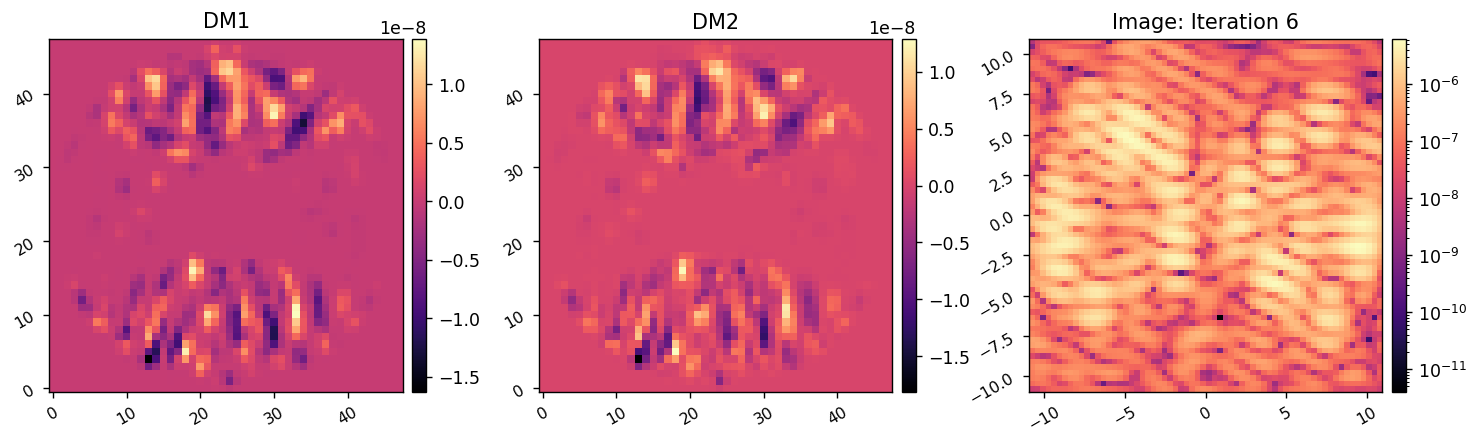

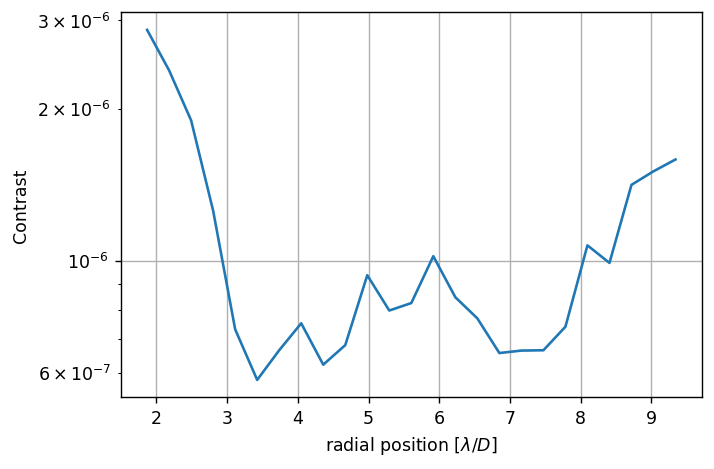

	Closed-loop iteration 7 / 10


(3560,)

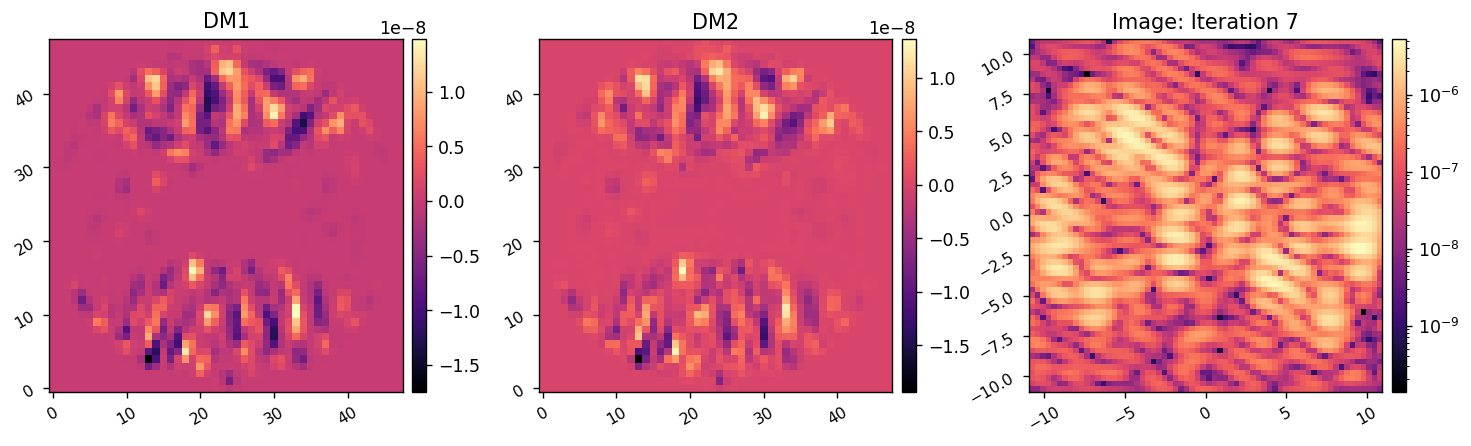

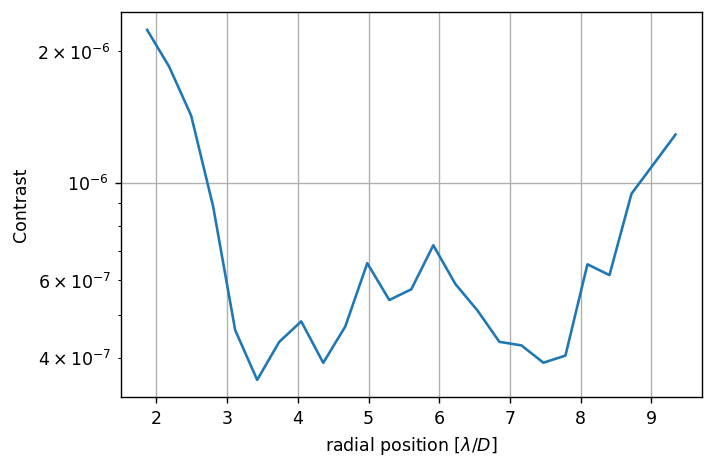

	Closed-loop iteration 8 / 10


(3560,)

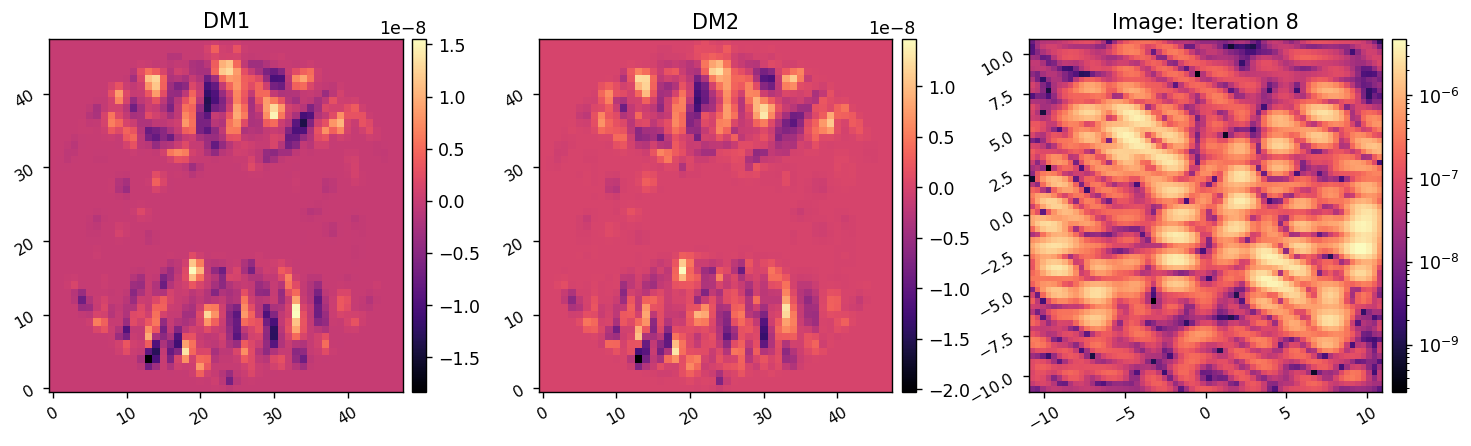

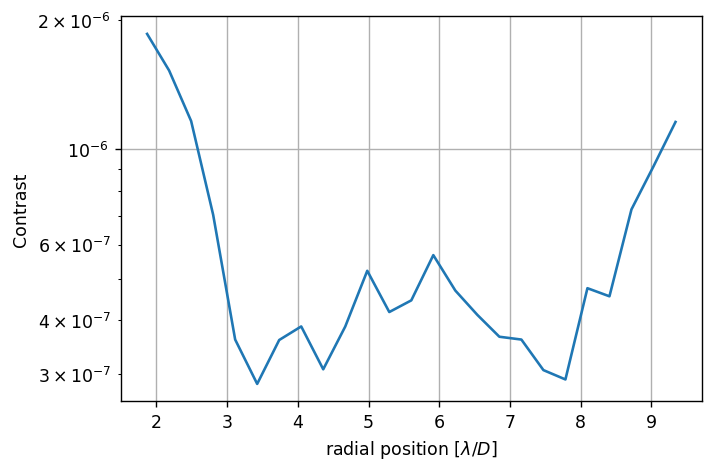

	Closed-loop iteration 9 / 10


(3560,)

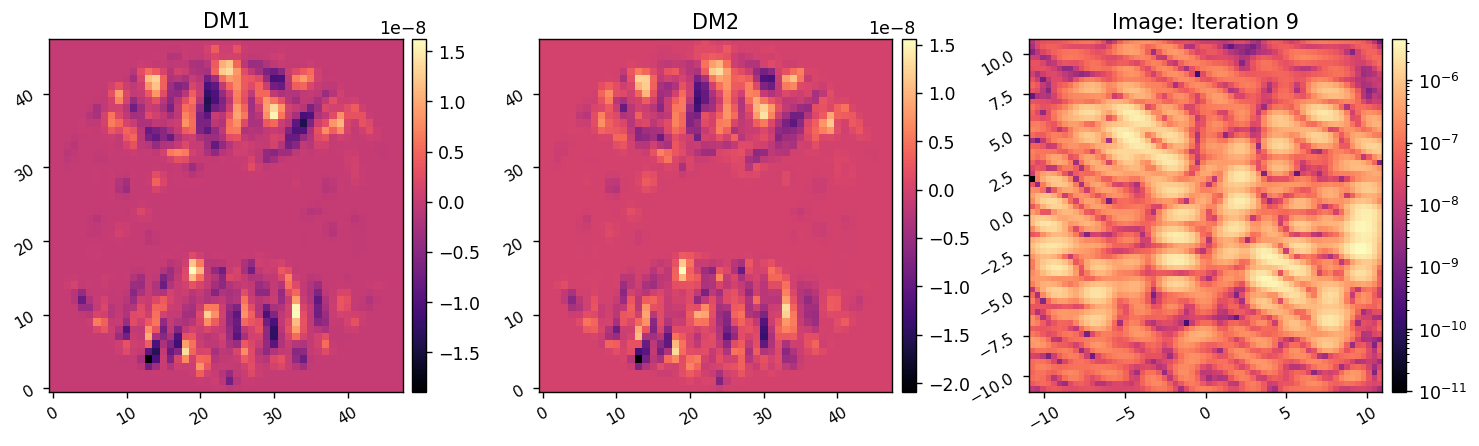

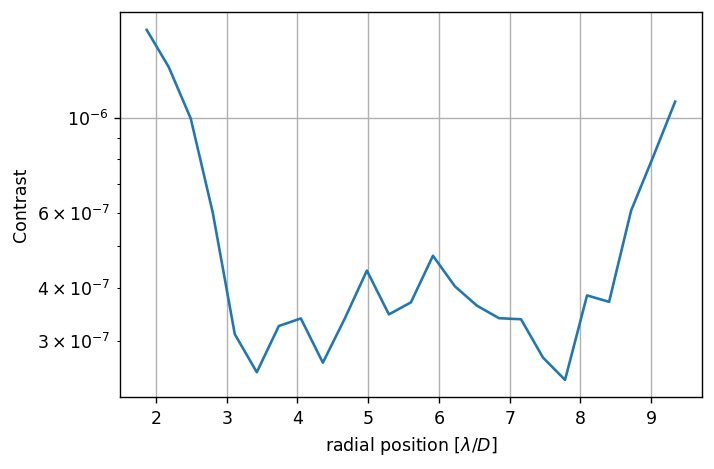

	Closed-loop iteration 10 / 10


(3560,)

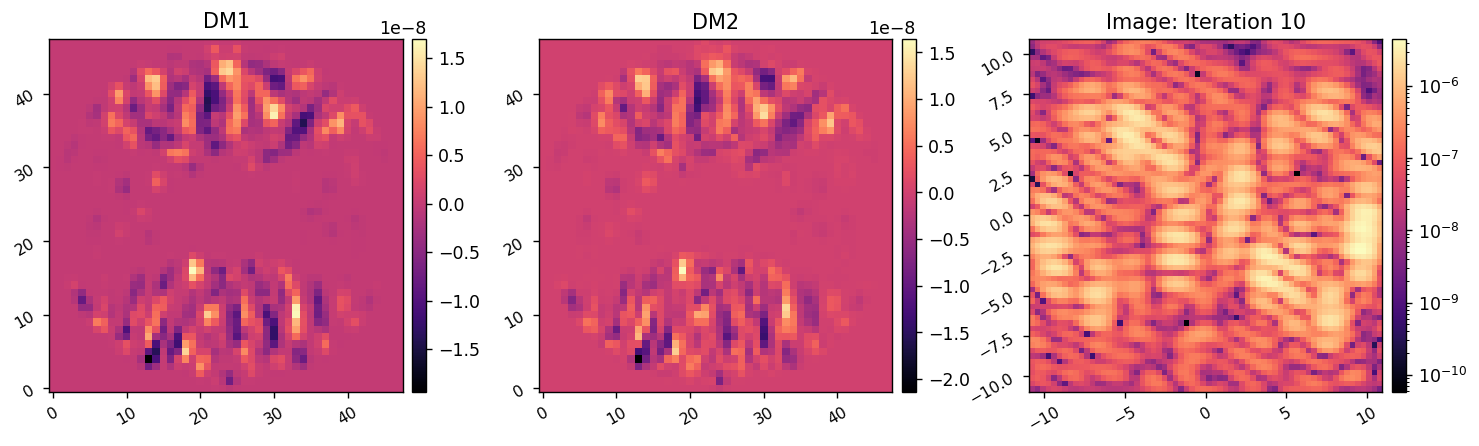

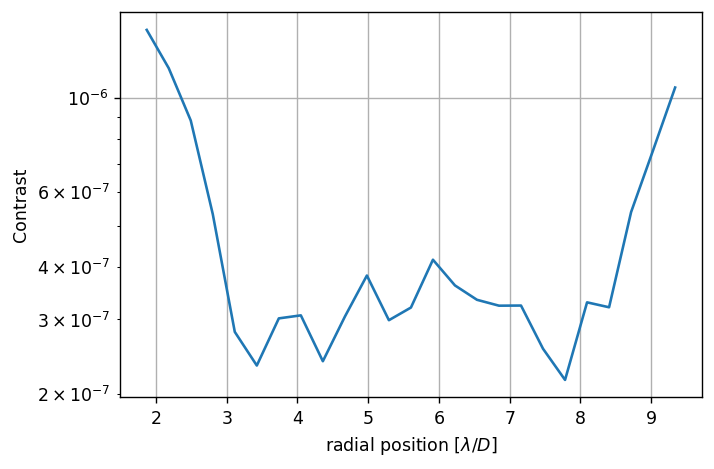

I-EFC loop completed in 22.588s.


In [12]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

(1808, 1808) (1808, 3560)
Running I-EFC...
	Closed-loop iteration 1 / 10


(3560,)

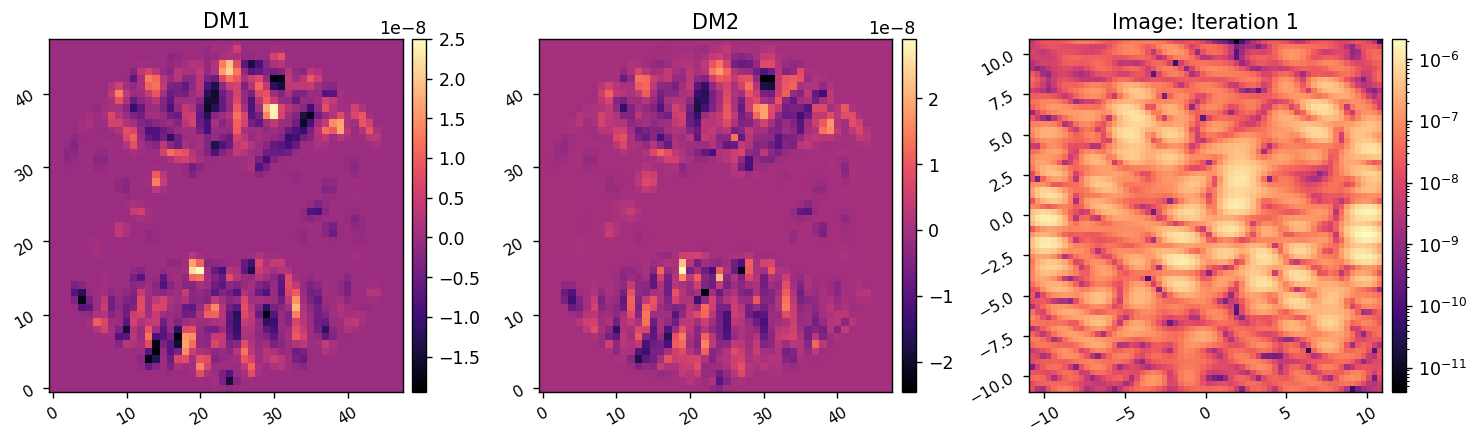

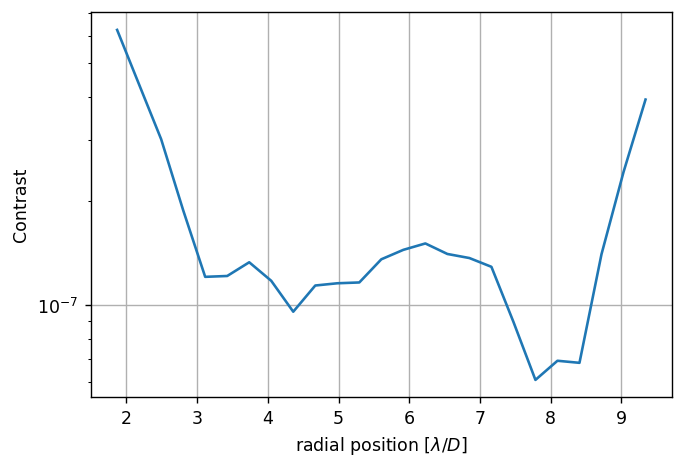

	Closed-loop iteration 2 / 10


(3560,)

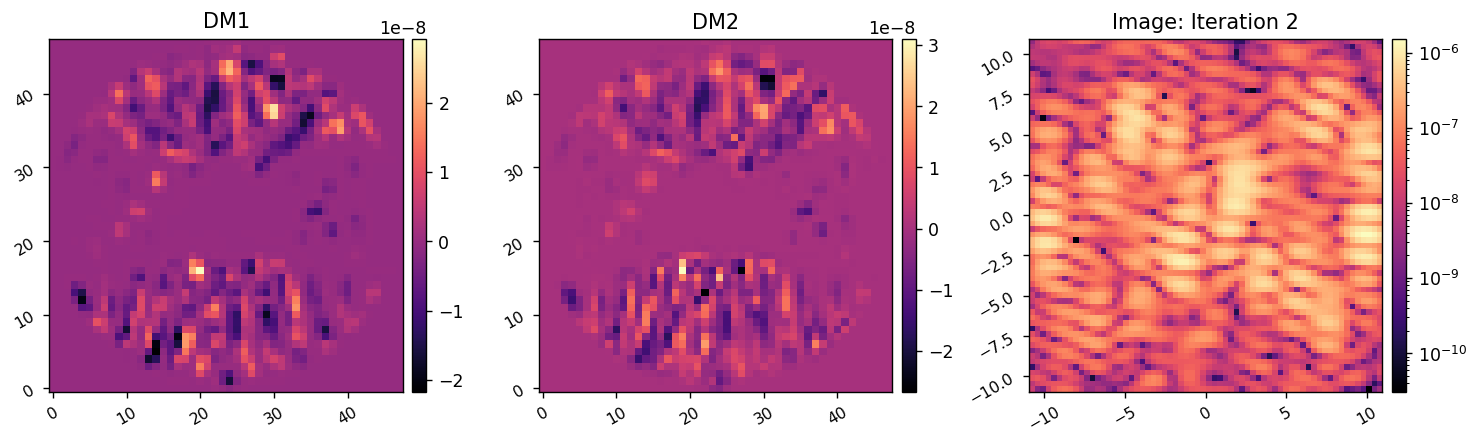

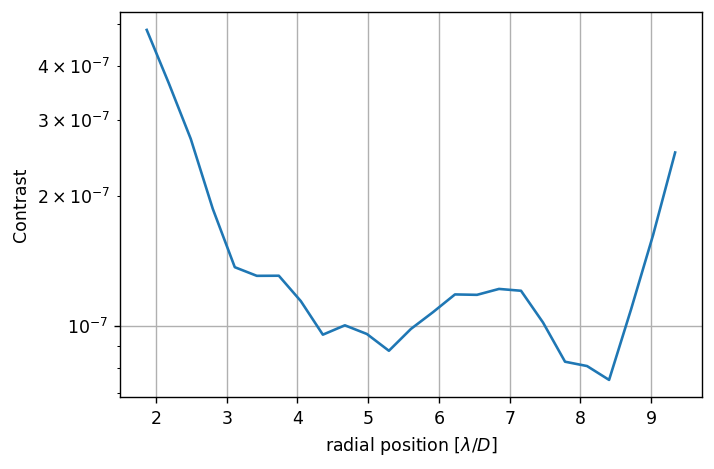

	Closed-loop iteration 3 / 10


(3560,)

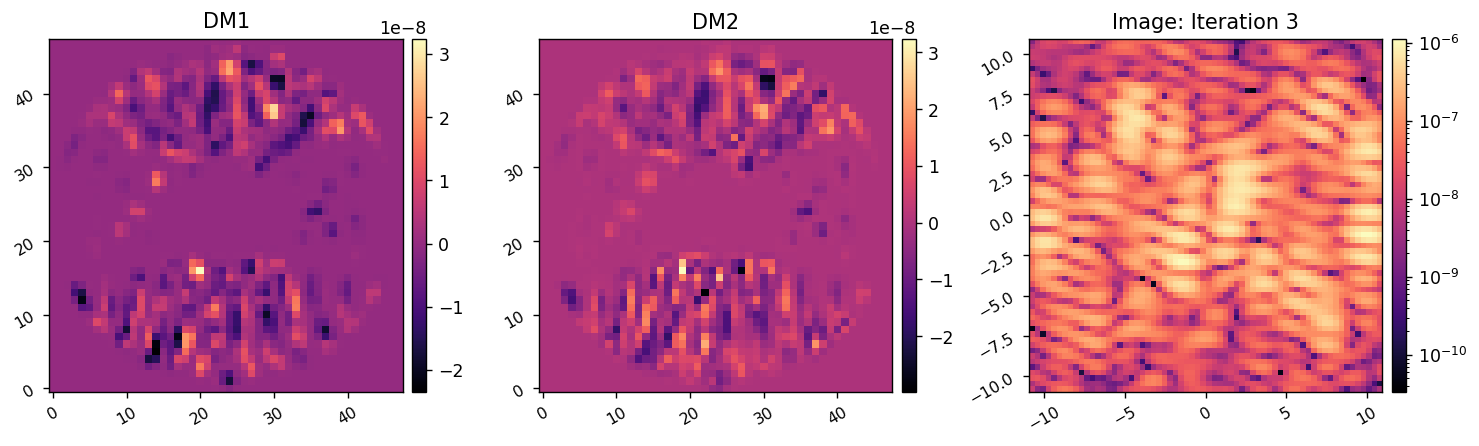

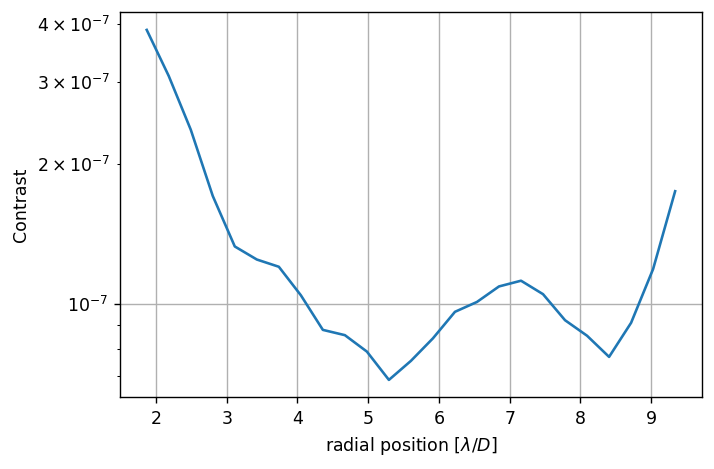

	Closed-loop iteration 4 / 10


(3560,)

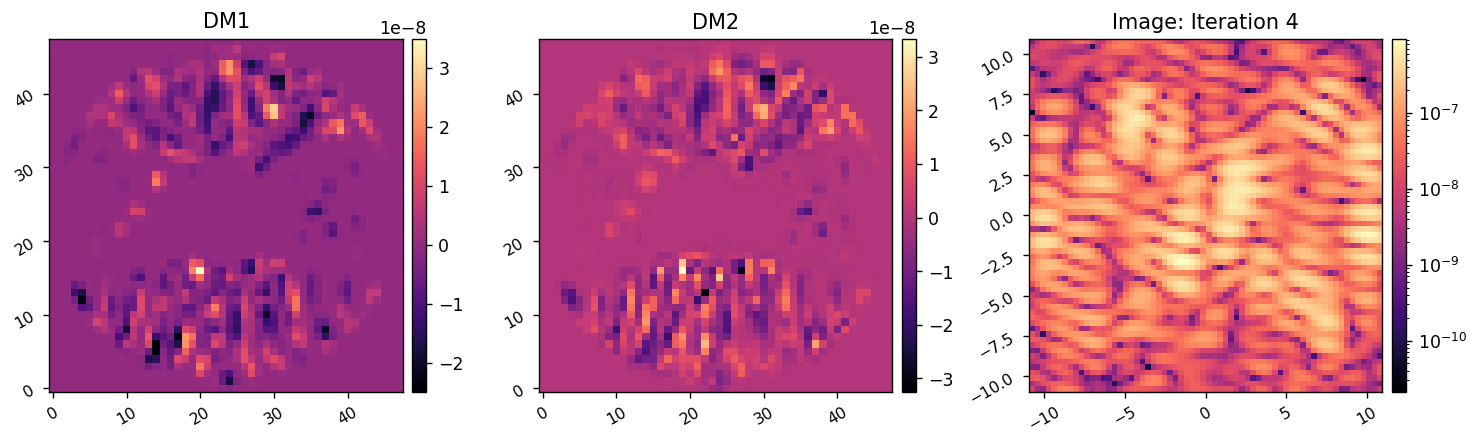

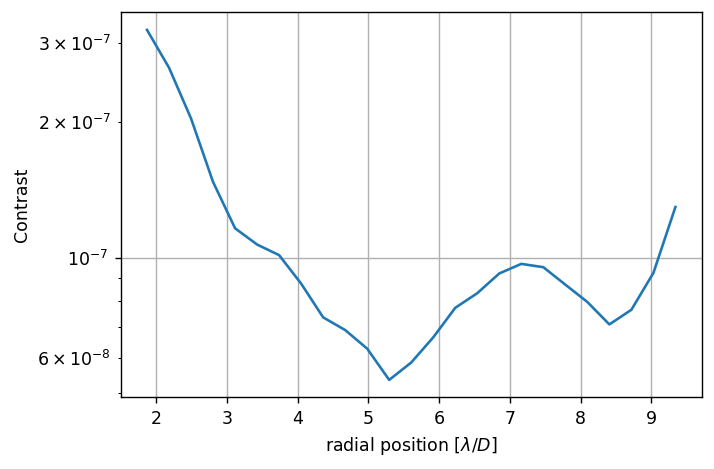

	Closed-loop iteration 5 / 10


(3560,)

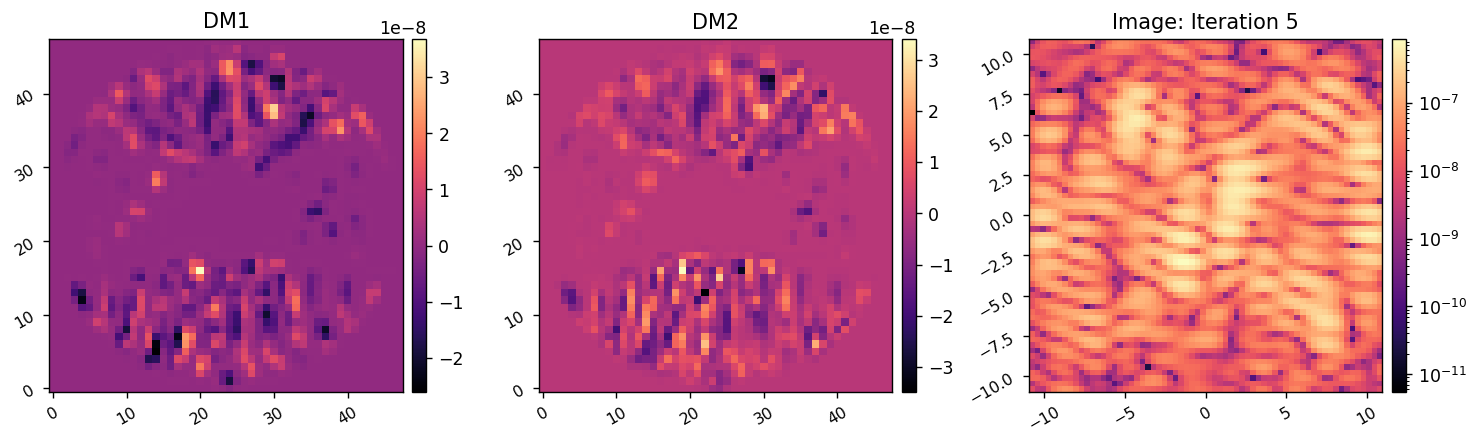

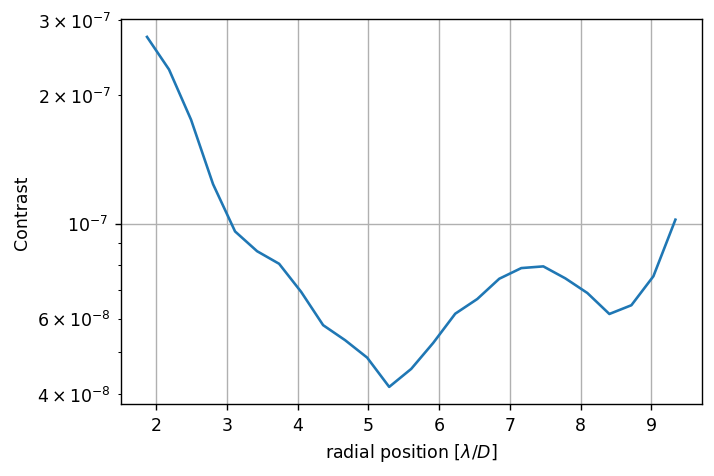

	Closed-loop iteration 6 / 10


(3560,)

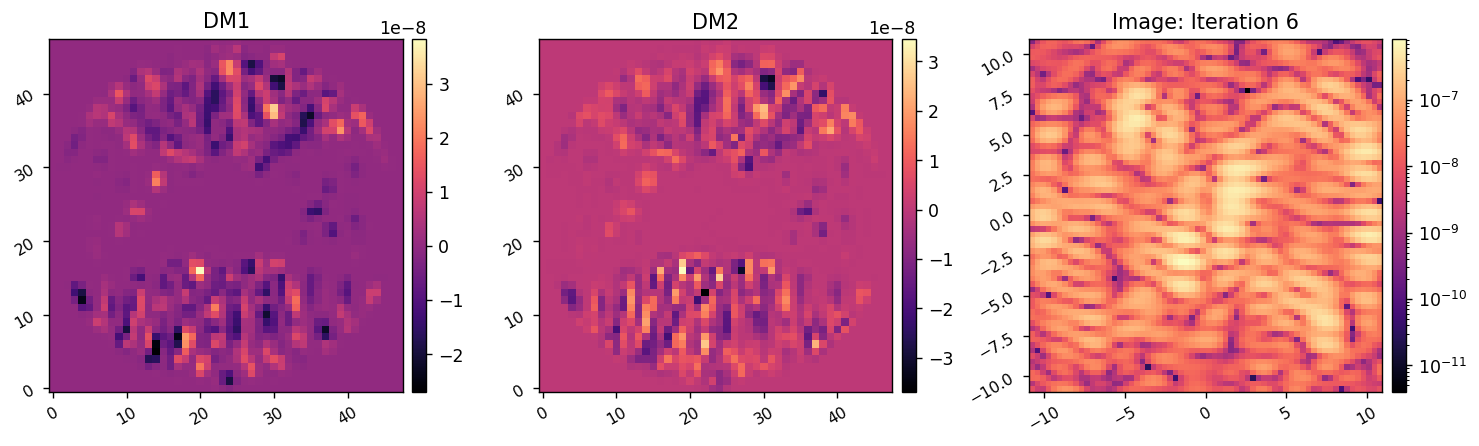

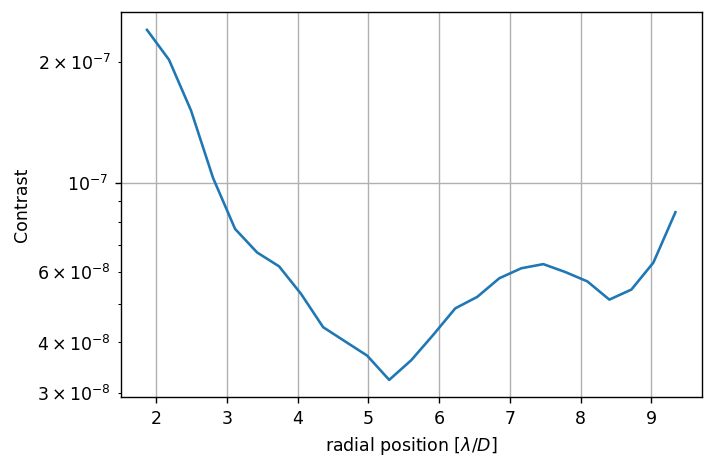

	Closed-loop iteration 7 / 10


(3560,)

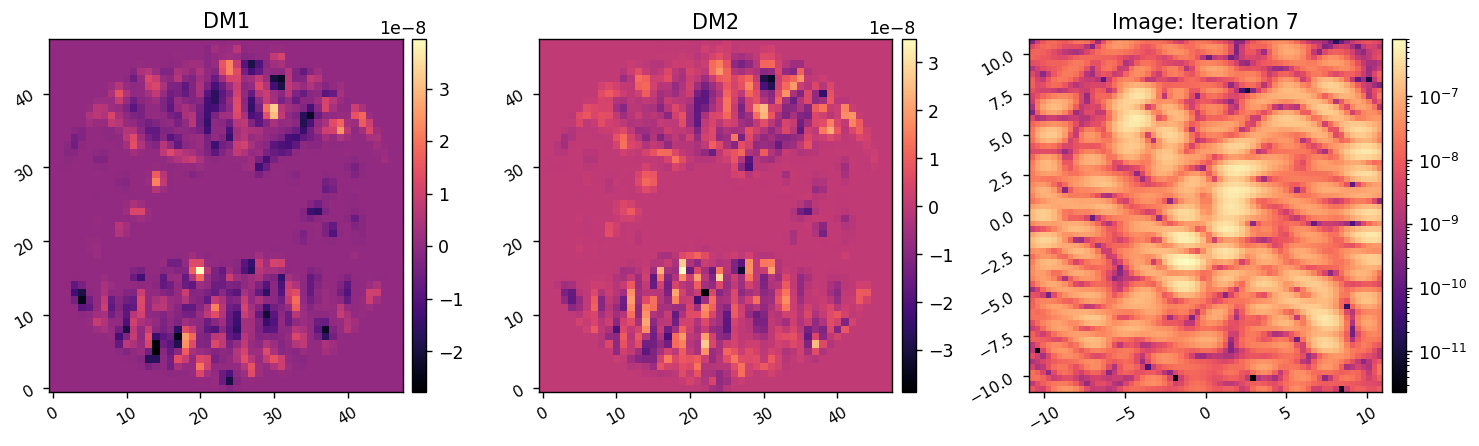

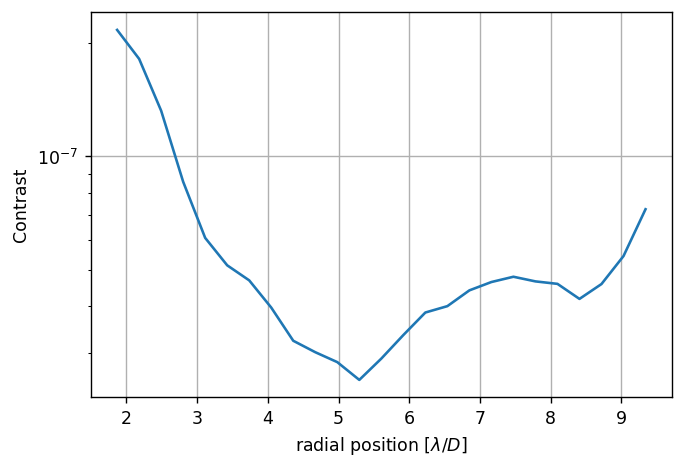

	Closed-loop iteration 8 / 10


(3560,)

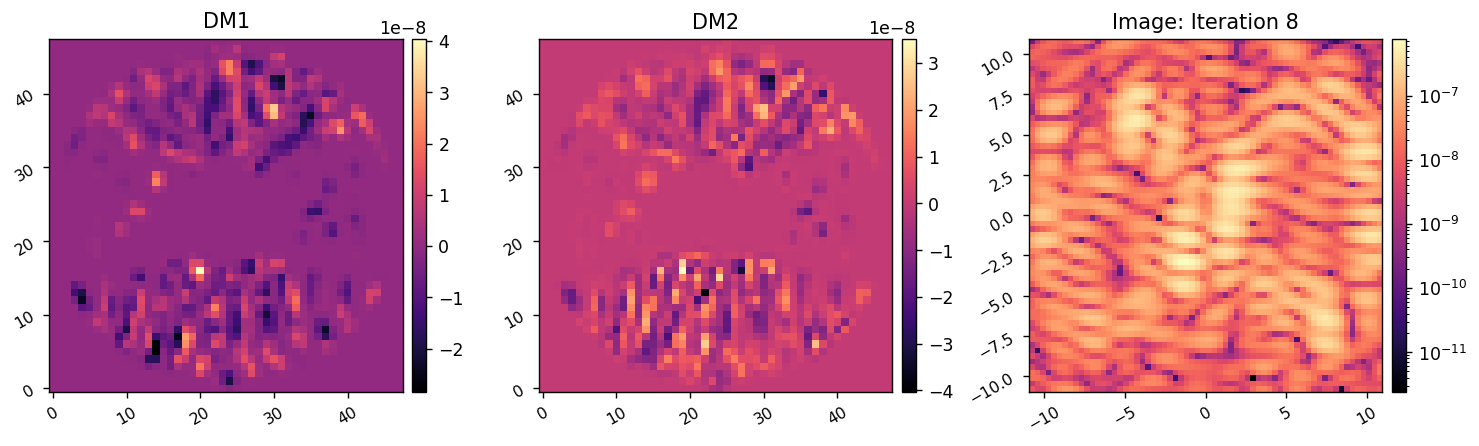

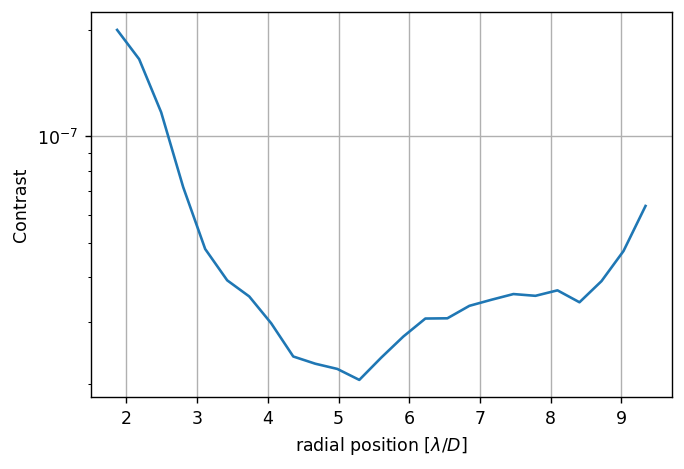

	Closed-loop iteration 9 / 10


(3560,)

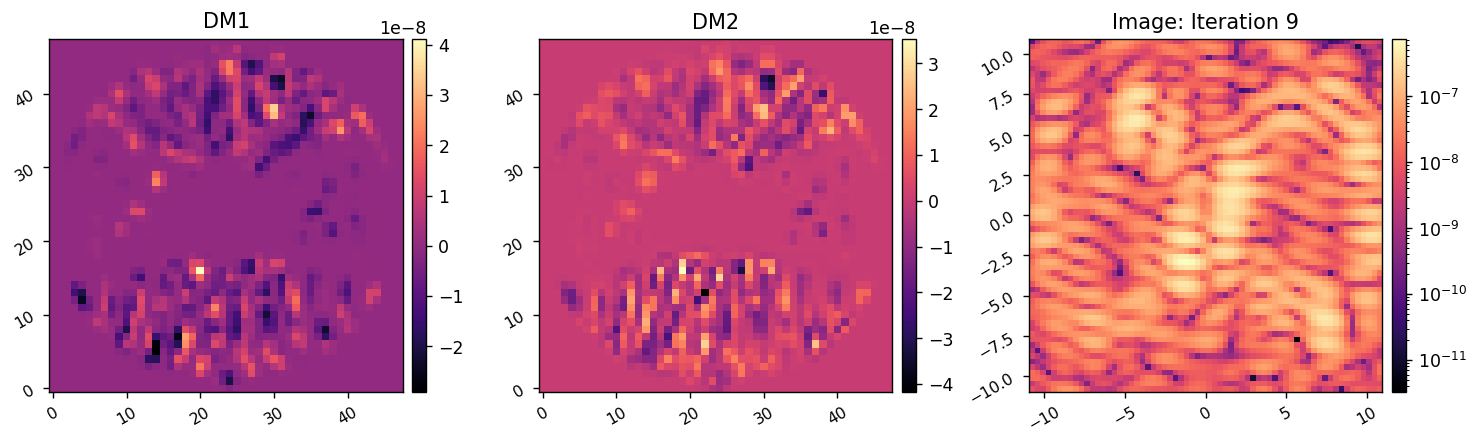

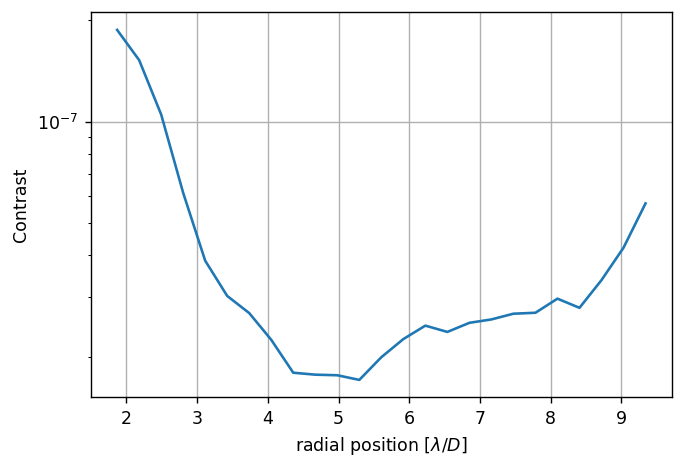

	Closed-loop iteration 10 / 10


(3560,)

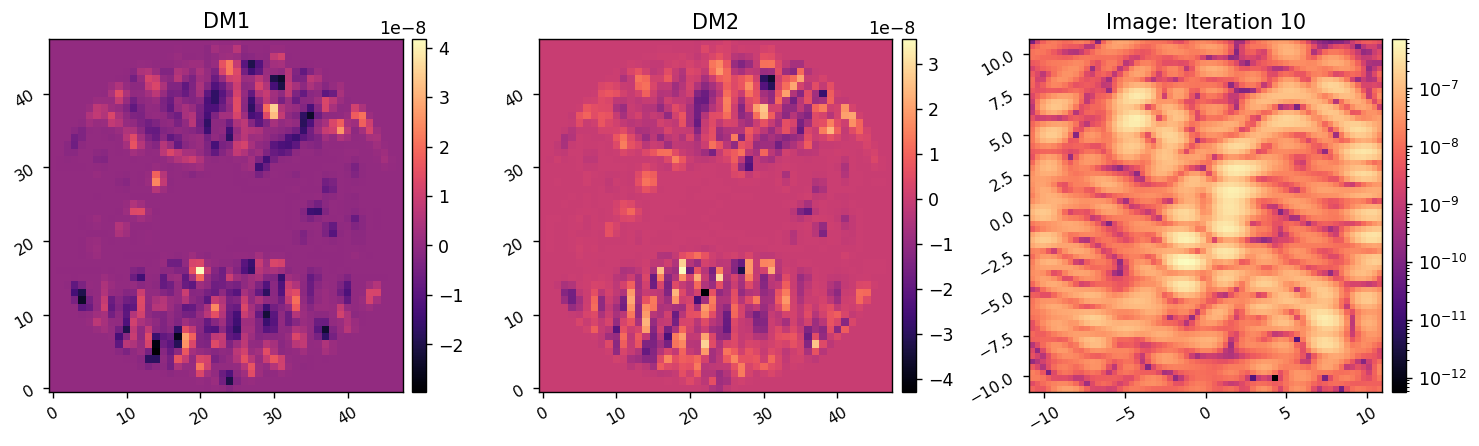

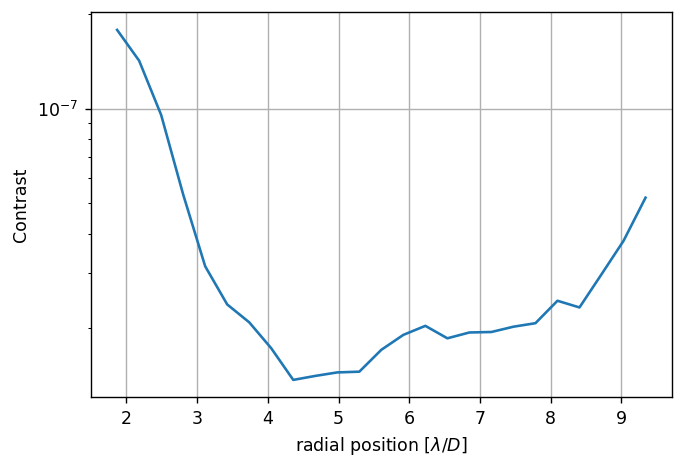

I-EFC loop completed in 22.676s.


In [14]:
reg_cond = 1e-3
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

(1808, 1808) (1808, 3560)
Running I-EFC...
	Closed-loop iteration 1 / 10


(3560,)

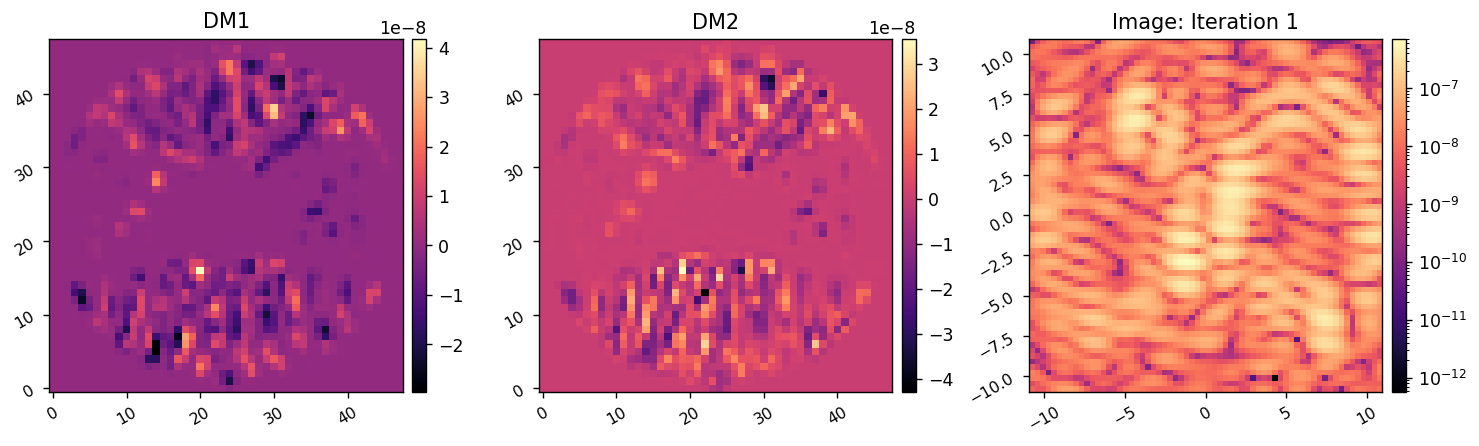

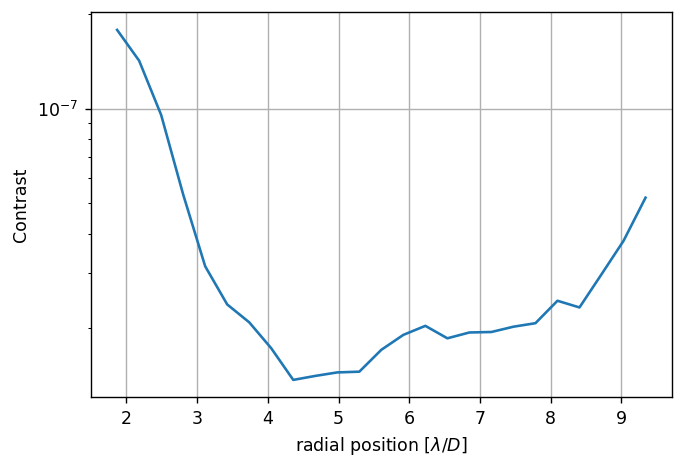

	Closed-loop iteration 2 / 10


(3560,)

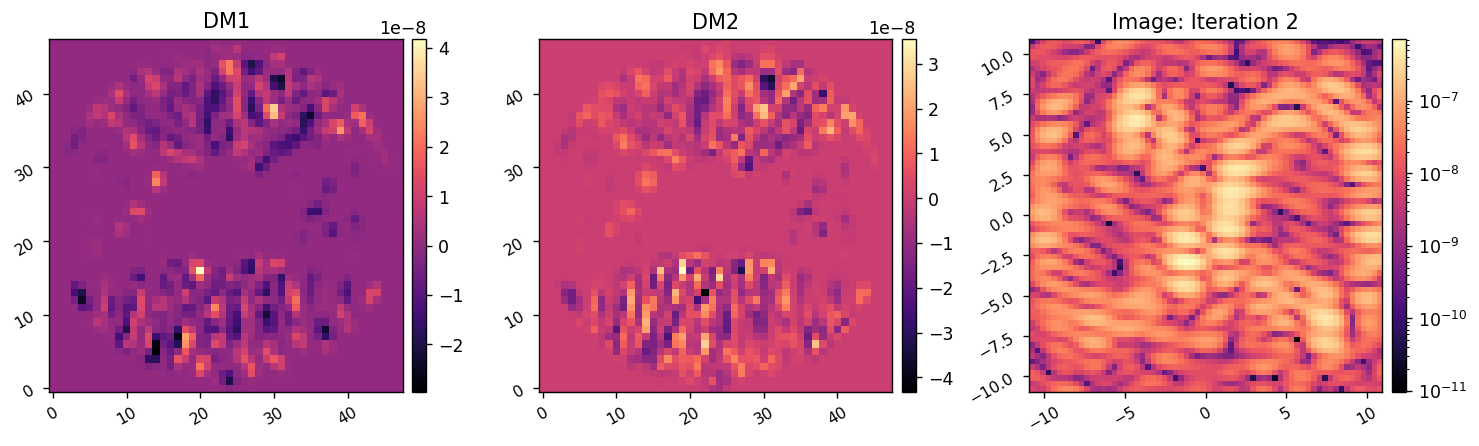

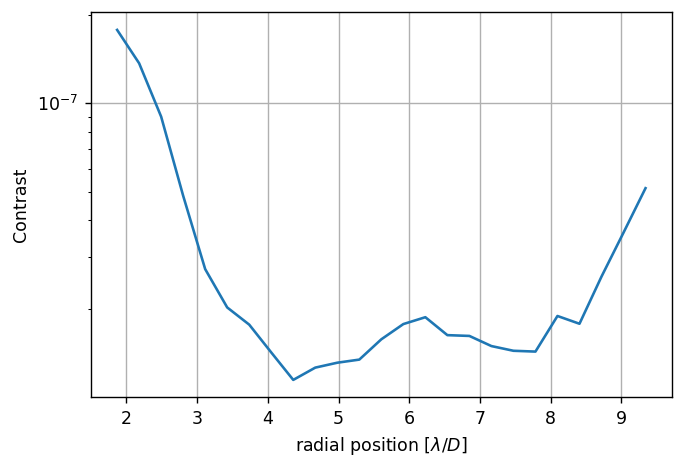

	Closed-loop iteration 3 / 10


(3560,)

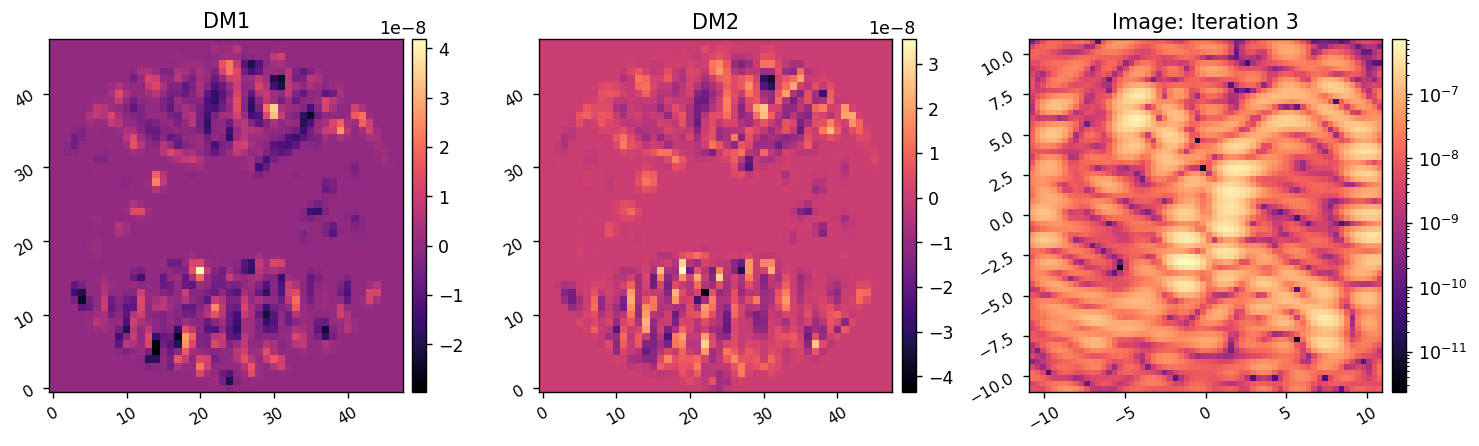

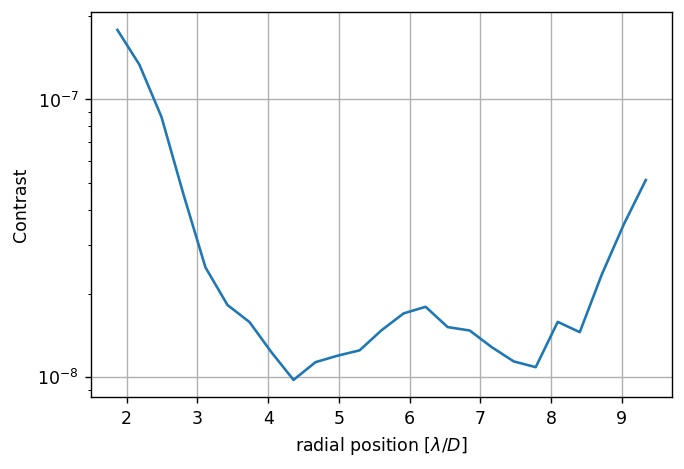

	Closed-loop iteration 4 / 10


(3560,)

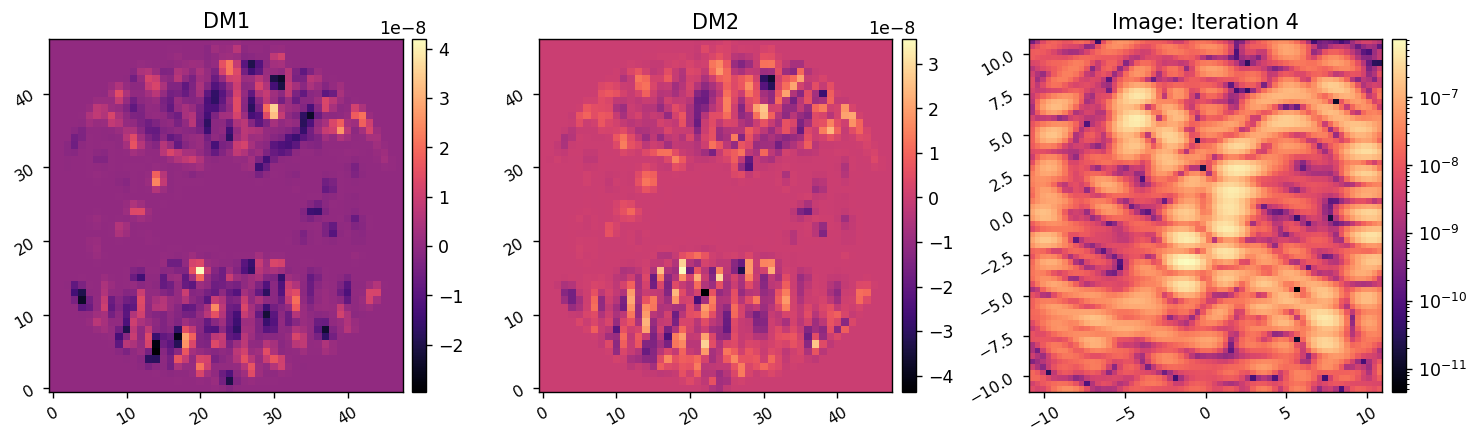

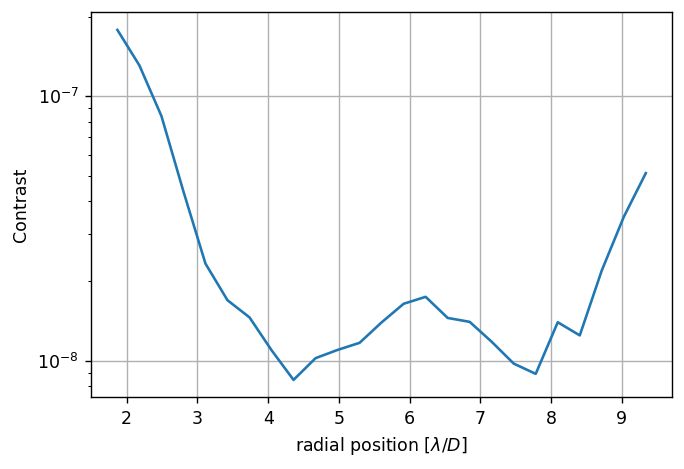

	Closed-loop iteration 5 / 10


(3560,)

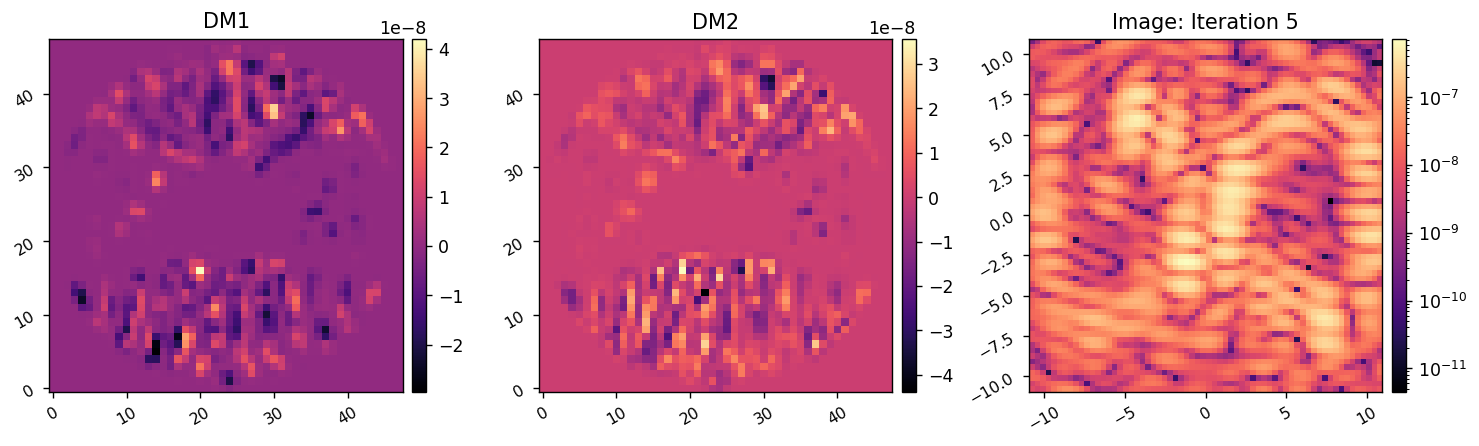

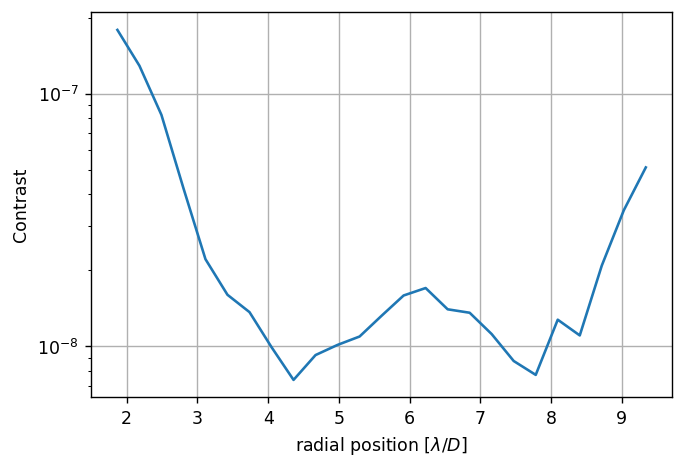

	Closed-loop iteration 6 / 10


(3560,)

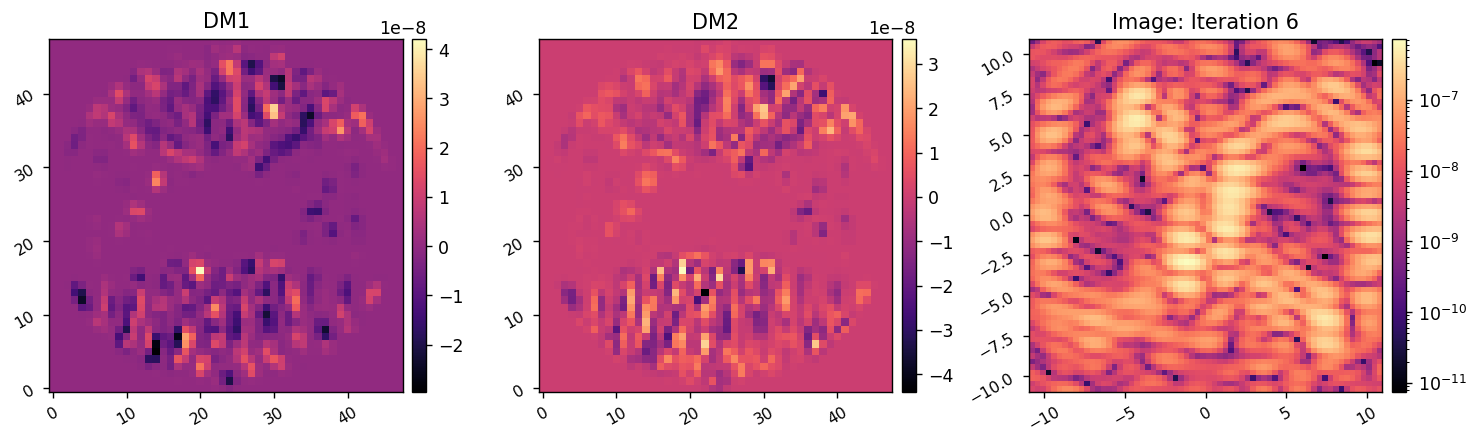

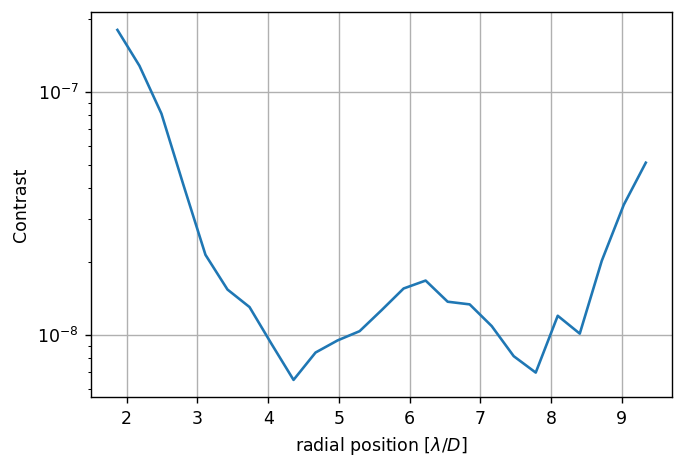

	Closed-loop iteration 7 / 10


(3560,)

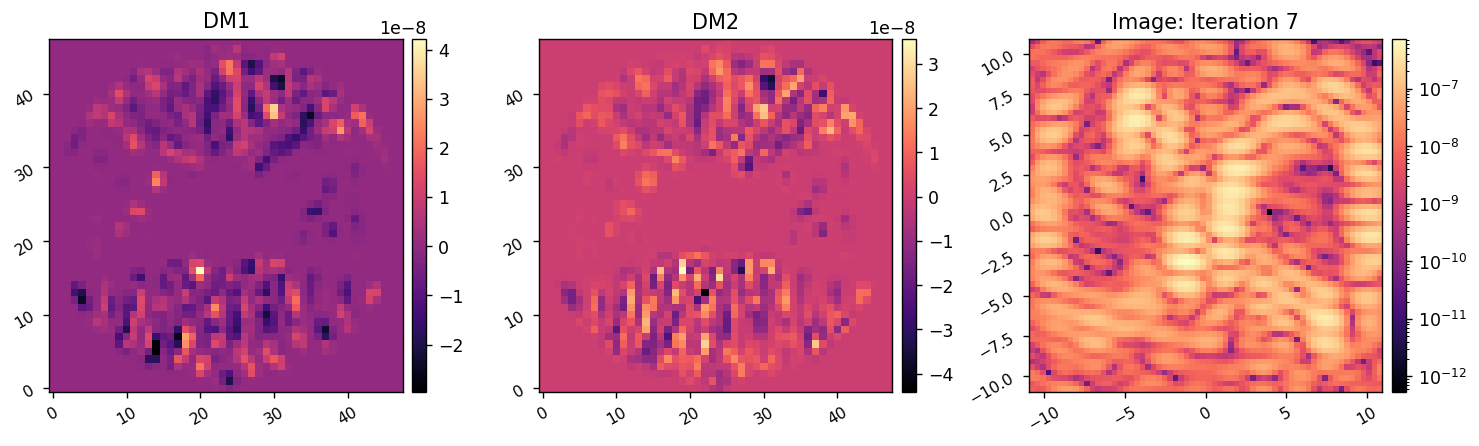

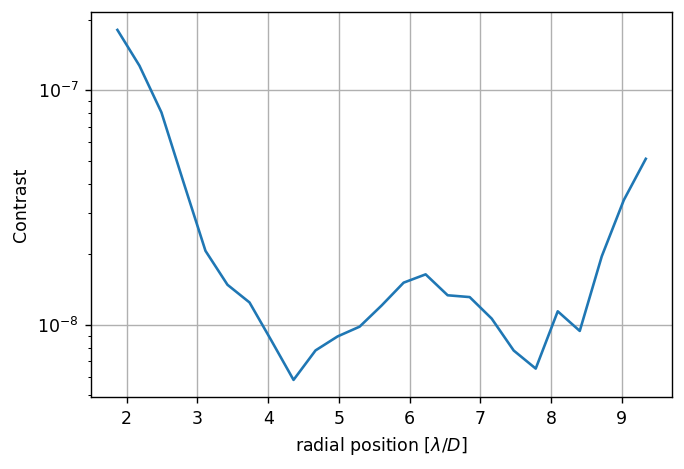

	Closed-loop iteration 8 / 10


(3560,)

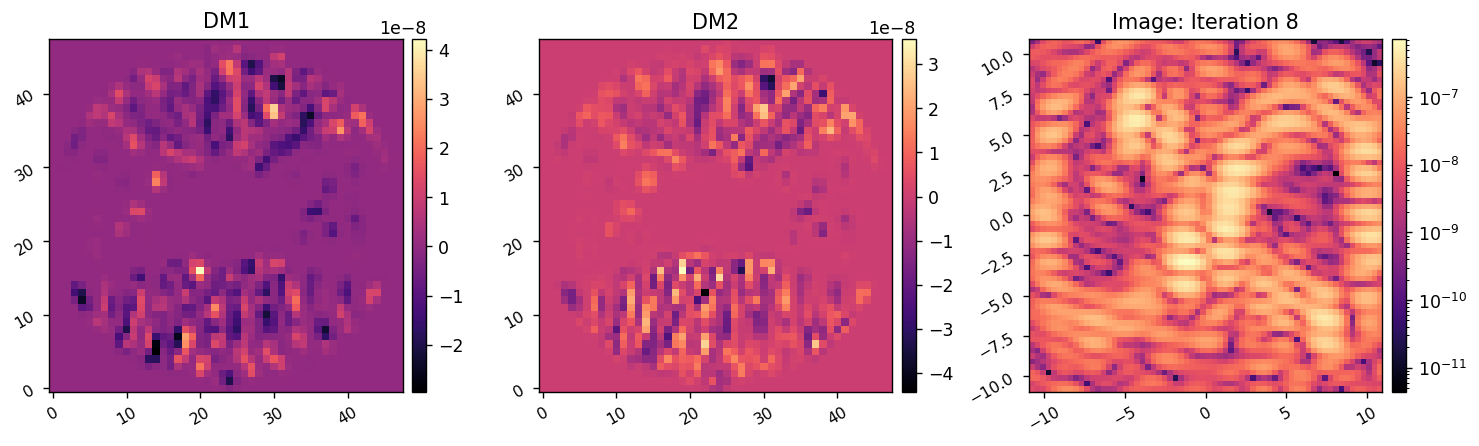

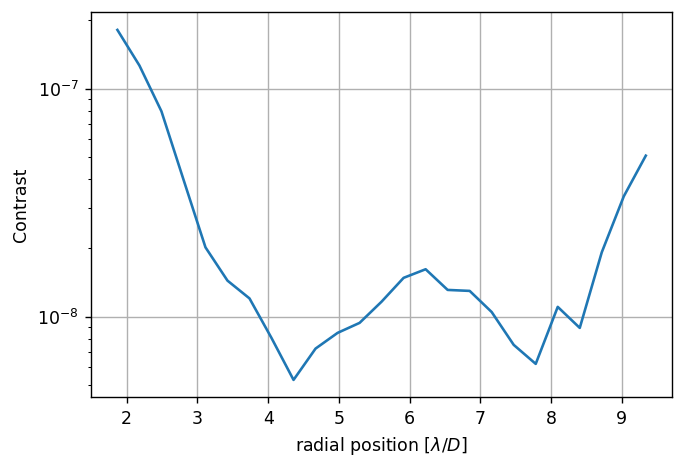

	Closed-loop iteration 9 / 10


(3560,)

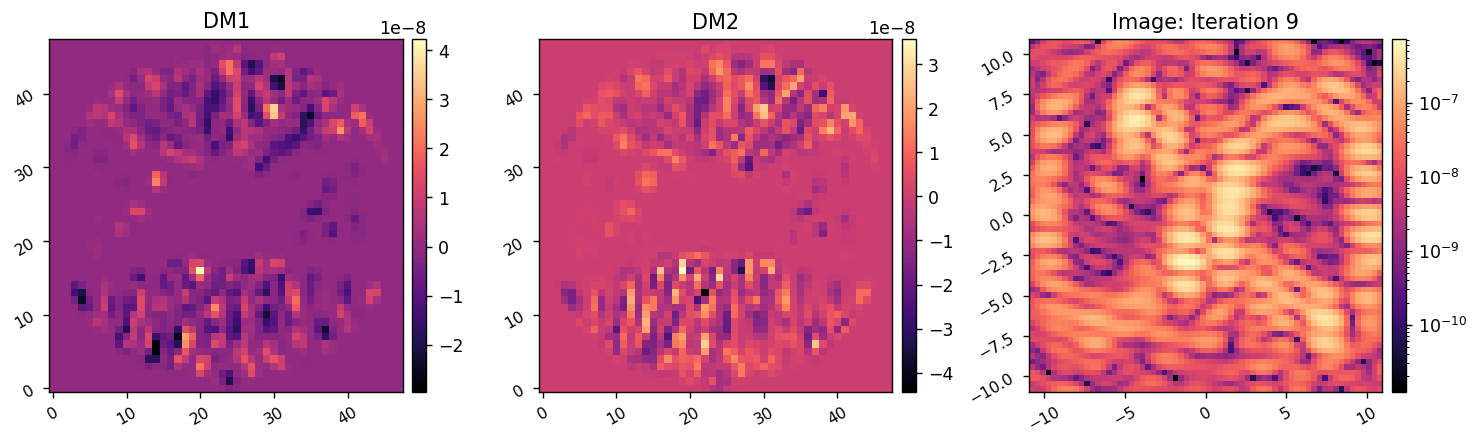

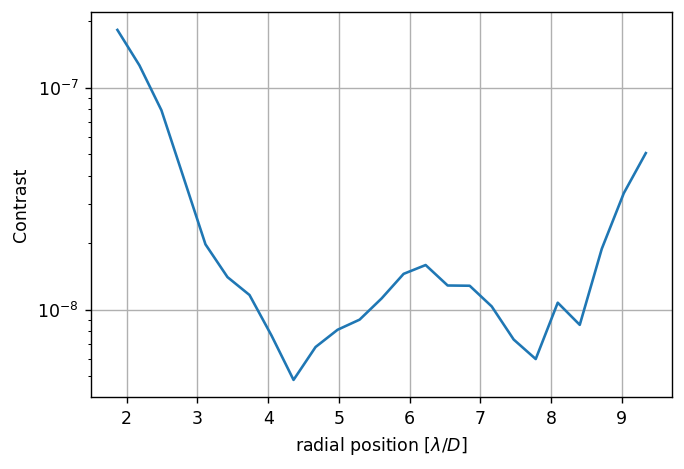

	Closed-loop iteration 10 / 10


(3560,)

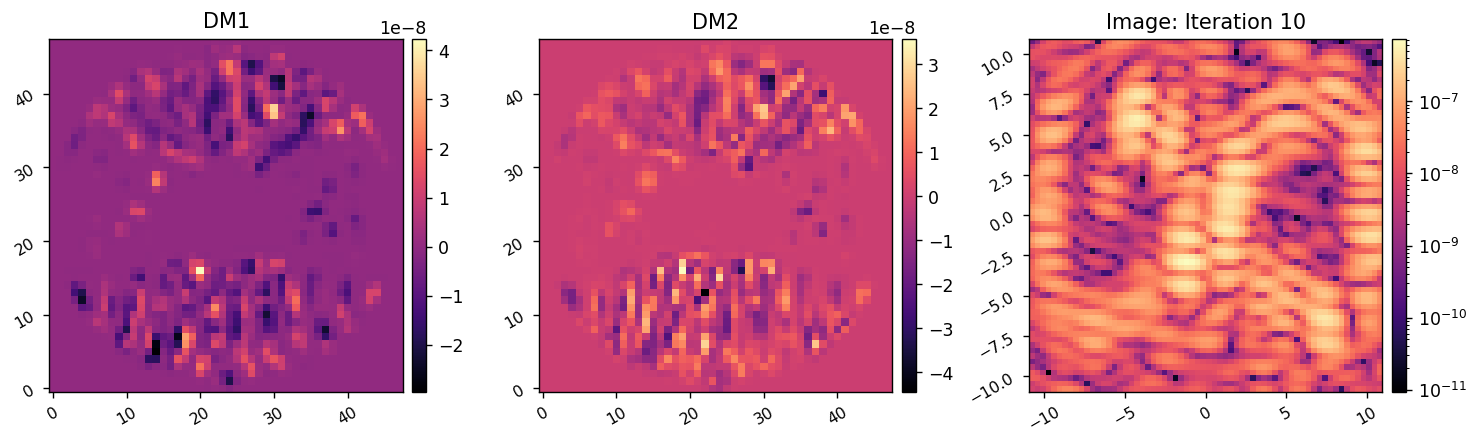

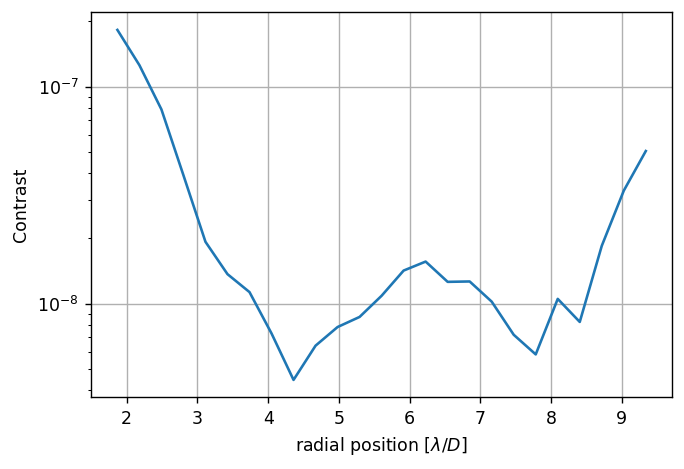

I-EFC loop completed in 22.681s.


In [15]:
reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

(1808, 1808) (1808, 3560)
Running I-EFC...
	Closed-loop iteration 1 / 5


(3560,)

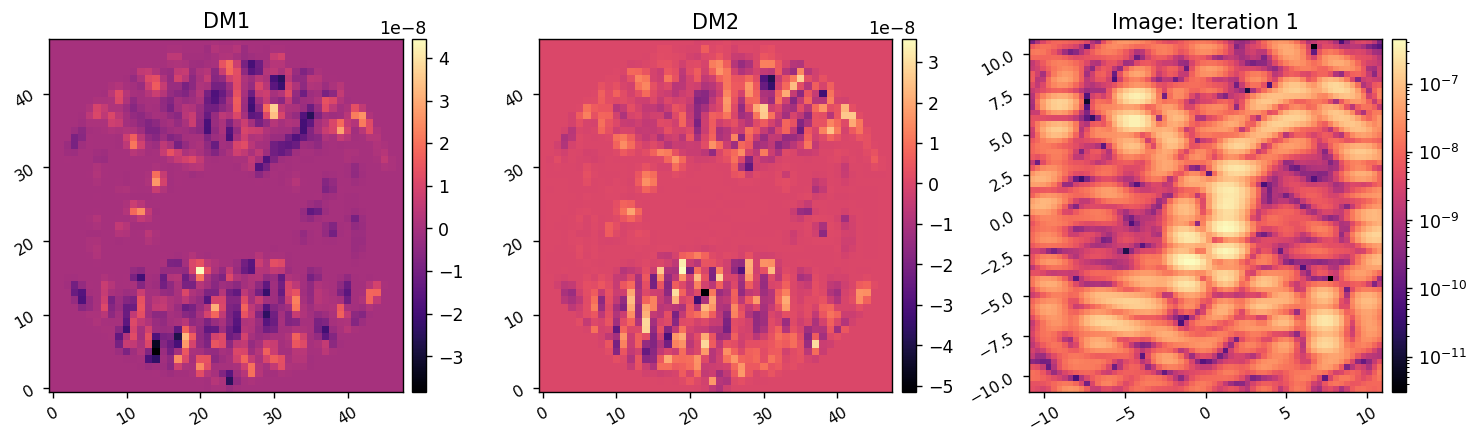

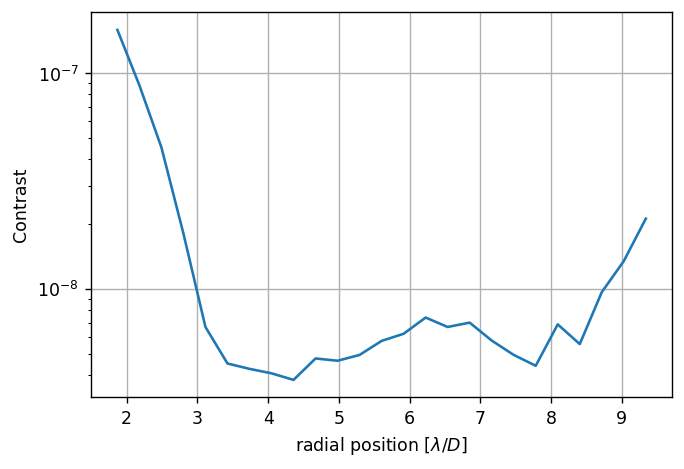

	Closed-loop iteration 2 / 5


(3560,)

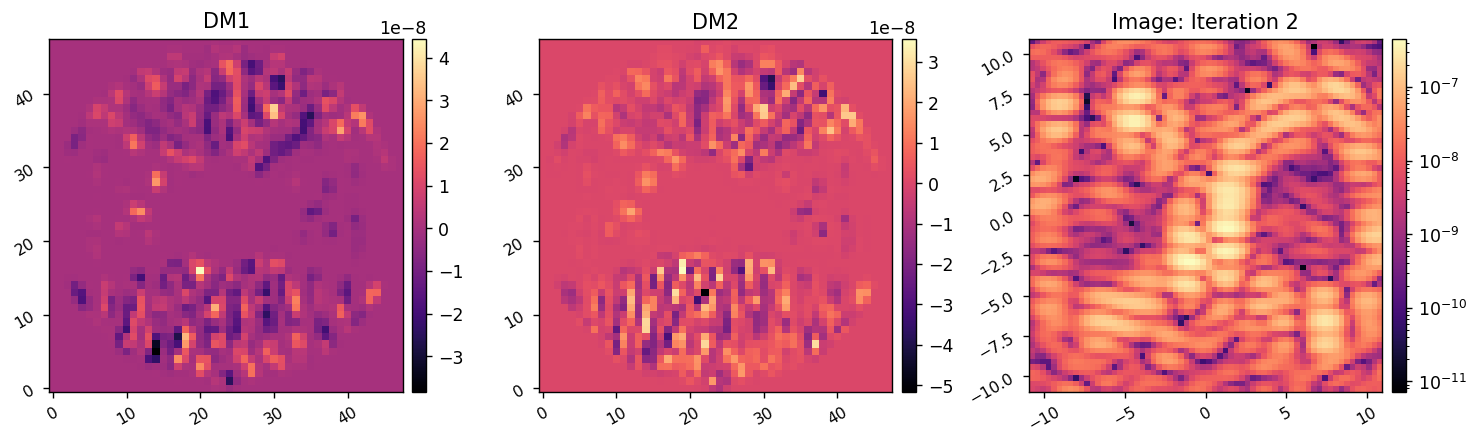

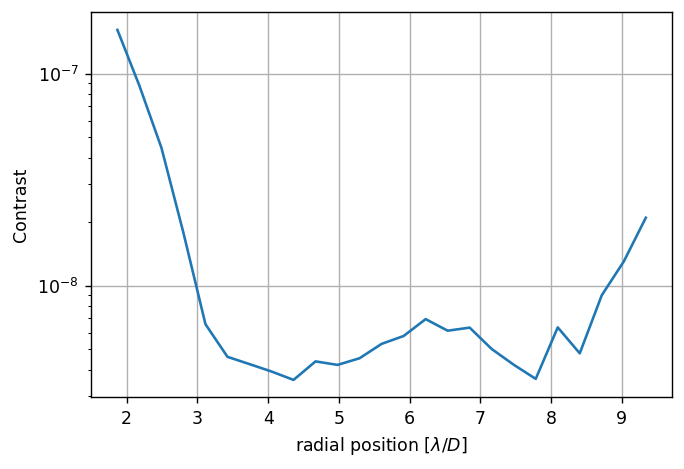

	Closed-loop iteration 3 / 5


(3560,)

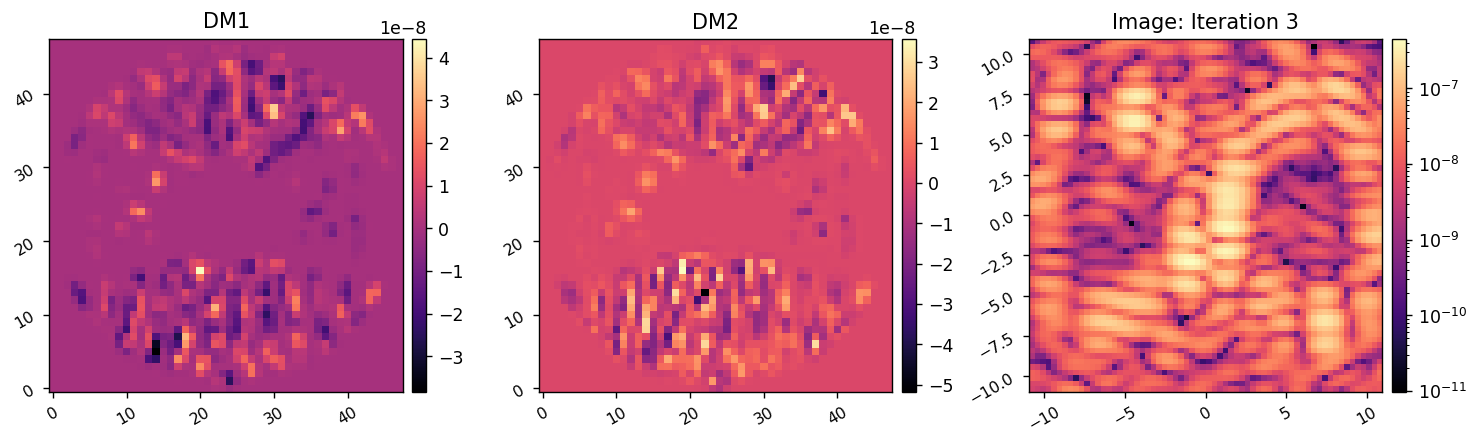

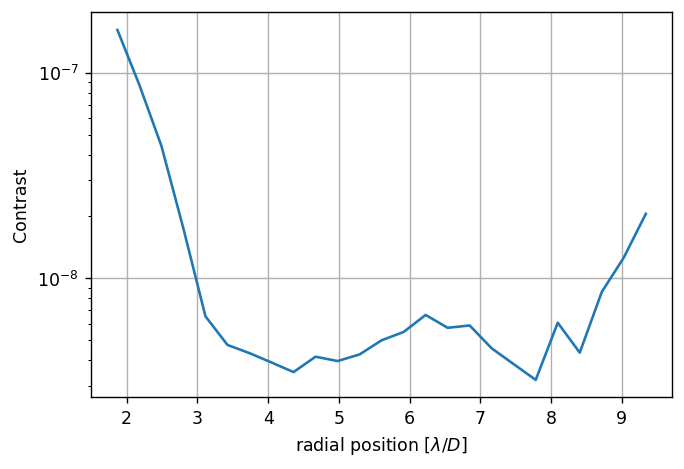

	Closed-loop iteration 4 / 5


(3560,)

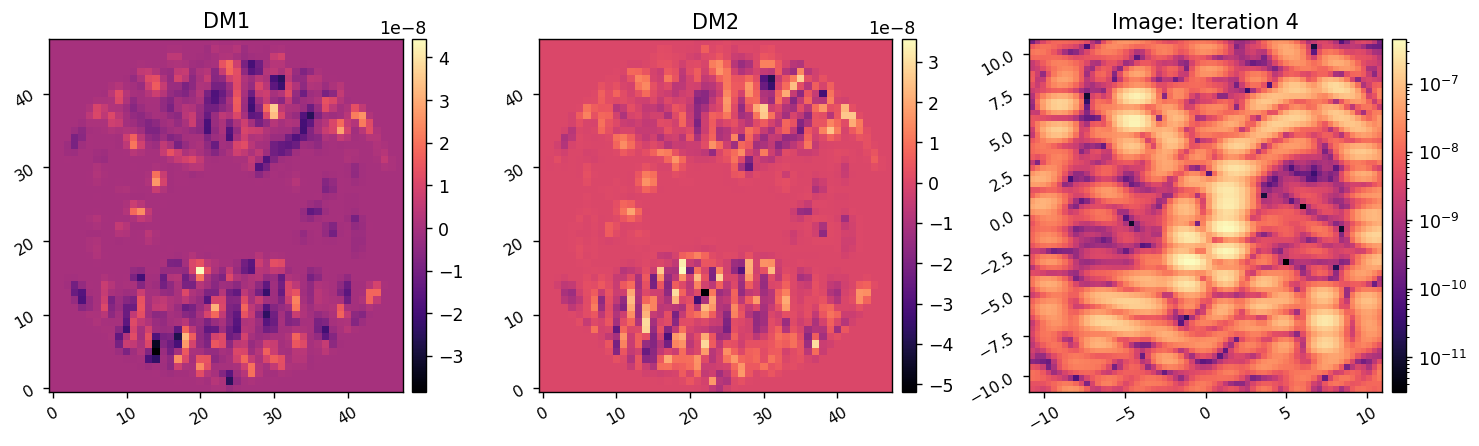

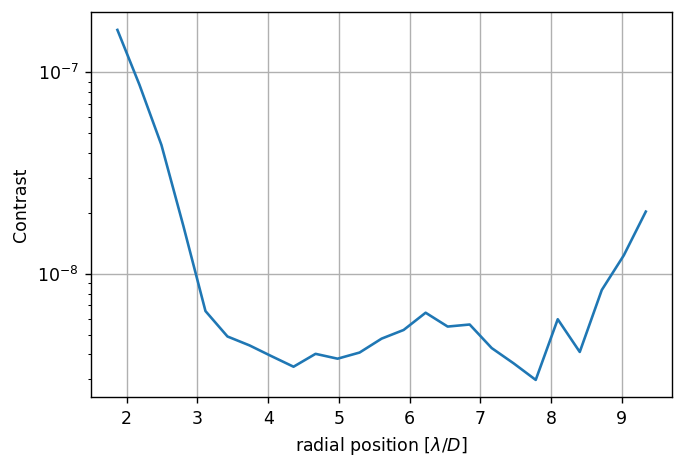

	Closed-loop iteration 5 / 5


(3560,)

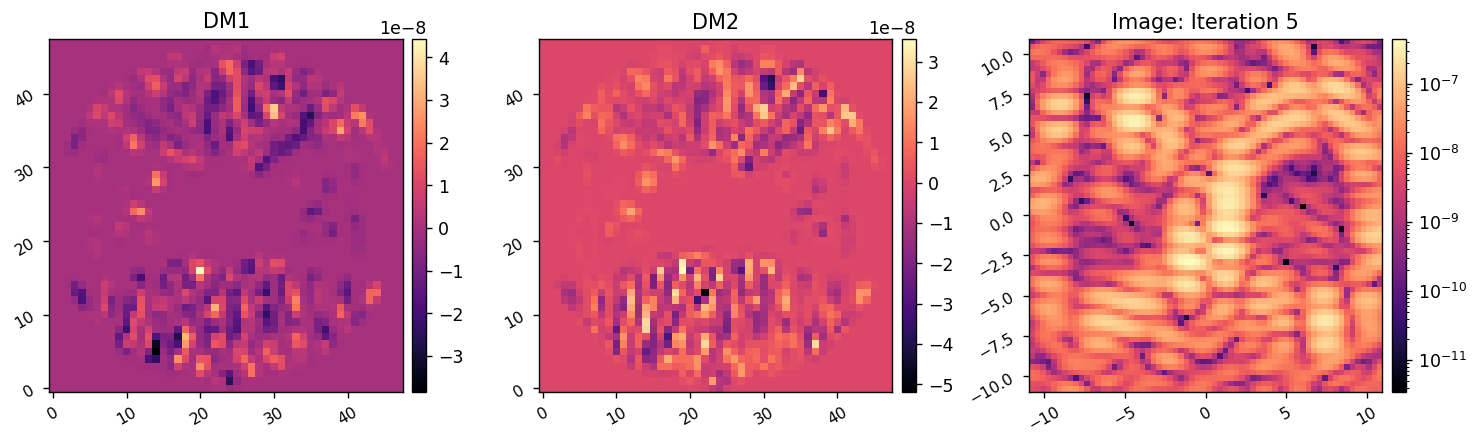

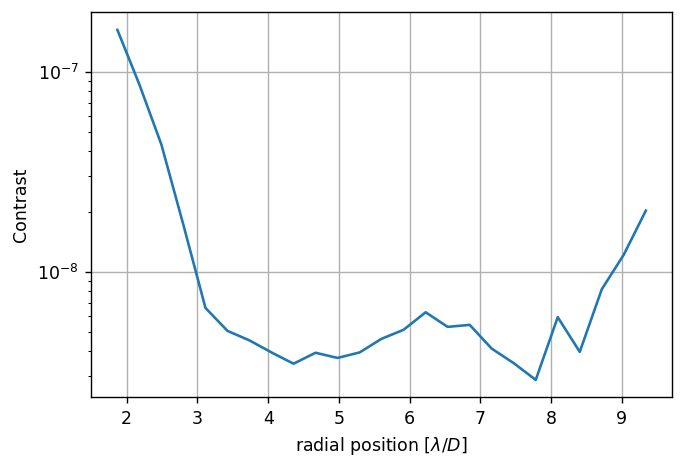

I-EFC loop completed in 11.399s.


In [18]:
reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

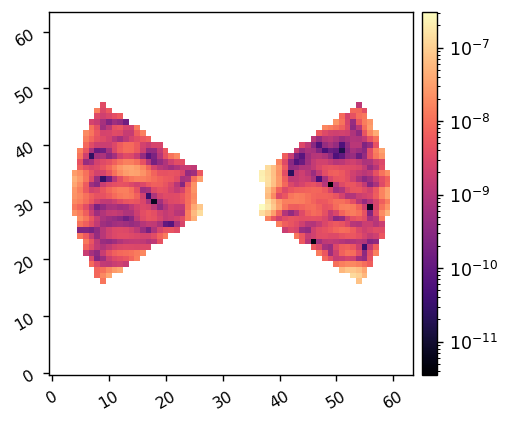

In [20]:
imshow1(images[-1]*control_mask, lognorm=True)